In [2]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from extractors import von_neumann, elias, universal_hash
from utils import compute_bias


import numpy as np
import matplotlib.pyplot as plt


In [3]:
pip install qiskit-ibm-runtime


Note: you may need to restart the kernel to use updated packages.


In [3]:
import qiskit

print(qiskit.version)




<module 'qiskit.version' from 'c:\\Users\\ereci\\anaconda3\\envs\\qrng-rl\\lib\\site-packages\\qiskit\\version.py'>


In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService


QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="57b729224f3cc9b915b34c45802ff022713a6f6b509e0d4a40ab14a14be0218859853759e0f2b420480dceb9885c105af056487aba55bf65ae17c22e43e542eb")

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

In [4]:
!pip show qiskit


Name: qiskit
Version: 2.0.1
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: c:\users\ereci\anaconda3\envs\qrng-rl\lib\site-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime


In [7]:
from qiskit import IBMQ


IBMQ.save_account("57b729224f3cc9b915b34c45802ff022713a6f6b509e0d4a40ab14a14be0218859853759e0f2b420480dceb9885c105af056487aba55bf65ae17c22e43e542eb")


ImportError: cannot import name 'IBMQ' from 'qiskit' (c:\Users\ereci\anaconda3\envs\qrng-rl\lib\site-packages\qiskit\__init__.py)

In [8]:
import os
os.getcwd()


'c:\\Users\\ereci\\OneDrive\\Desktop\\QRANDOPT\\QRANDOPT\\notebooks'

In [9]:
!pip install pytest

In [10]:
import pytest


exit_code = pytest.main([
    "--maxfail=1",
    "--disable-warnings",
    "-q",
])
print(f"pytest exited with code {exit_code}")



no tests ran in 0.00s
pytest exited with code 5


In [11]:

raw_bits = np.random.choice([0,1], size=1000, p=[0.8,0.2]).tolist()
print(f"Raw bias = {compute_bias(raw_bits):.3f}, length = {len(raw_bits)}")


Raw bias = 0.299, length = 1000


In [5]:

import sys, os
from pathlib import Path


p = Path().resolve()


while not (p / "extractors").is_dir():
    if p.parent == p:
        raise RuntimeError("Could not find project root (no 'extractors/' folder).")
    p = p.parent

project_root = p  


os.chdir(project_root)


if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✔️ Project root: {project_root}")
print(f"✔️ Working dir:   {os.getcwd()}")


✔️ Project root: C:\Users\ereci\OneDrive\Desktop\QRANDOPT\QRANDOPT
✔️ Working dir:   C:\Users\ereci\OneDrive\Desktop\QRANDOPT\QRANDOPT


In [13]:

import importlib, subprocess, sys

if importlib.util.find_spec("pytest") is None:
    print("Installing pytest…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytest"])
else:
    print("pytest already installed")


pytest already installed


Extractor     | Bias before | Bias after | Output len
              |             |            |           
         VN |       0.313 |      0.015 |        165
      Elias |       0.313 |      0.092 |        152
       Hash |       0.313 |      0.027 |        256
Maurer–Wolf |       0.313 |      0.010 |        496


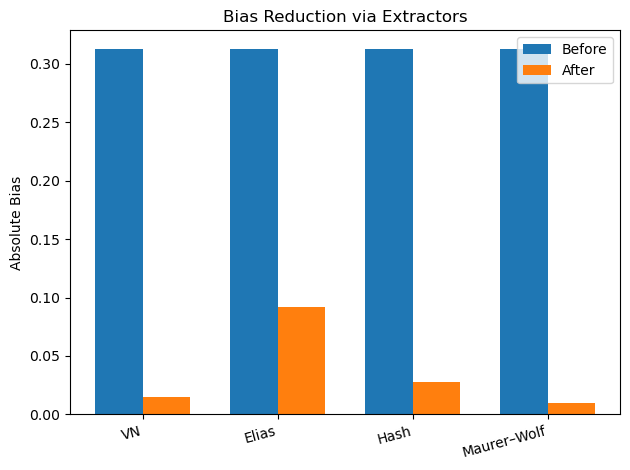

In [6]:
"""
compare_extractors.py
Bias comparison and plotting for classical extractors plus Maurer–Wolf.
"""
import pytest
import numpy as np
import matplotlib.pyplot as plt

from extractors.von_neumann    import von_neumann
from extractors.elias          import elias
from extractors.universal_hash import universal_hash
from extractors.maurer_wolf    import maurer_wolf_extractor
from utils                     import compute_bias

def bits_to_bytes(bits):
    """Pack list of 0/1 bits into a bytes object (MSB-first)."""
   
    pad = (-len(bits)) % 8
    bits = bits + [0]*pad
    output = bytearray()
    for i in range(0, len(bits), 8):
        byte = 0
        for b in bits[i:i+8]:
            byte = (byte << 1) | b
        output.append(byte)
    return bytes(output)

def bytes_to_bits(b):
    """Unpack bytes into list of bits (MSB-first)."""
    bits = []
    for byte in b:
        for shift in range(7, -1, -1):
            bits.append((byte >> shift) & 1)
    return bits


raw_bits = np.random.choice([0, 1], size=1000, p=[0.8, 0.2]).tolist()

# Applying extractors & computing bias
results = {}
for name, fn in [
    ("VN",          von_neumann),
    ("Elias",       elias),
    ("Hash",        lambda bits: universal_hash(bits, seed="abc")),
    ("Maurer–Wolf", None)  
]:
    if name != "Maurer–Wolf":
        out = fn(raw_bits)
    else:
        # preparing inputs for the byte-based extractor
        raw_bytes = bits_to_bytes(raw_bits)
        seed      = b"abc"              
        out_len   = len(raw_bytes) // 2 
        extracted = maurer_wolf_extractor(raw_bytes, seed, out_len)
        out = bytes_to_bits(extracted)

    results[name] = (compute_bias(raw_bits), compute_bias(out), len(out))

# Print summary table
print("Extractor     | Bias before | Bias after | Output len")
print("              |             |            |           ")
for name, (b0, b1, L) in results.items():
    print(f"{name:>11} | {b0:>11.3f} | {b1:>10.3f} | {L:>10}")

# Plot bias reduction
labels = list(results.keys())
before = [v[0] for v in results.values()]
after  = [v[1] for v in results.values()]
x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots()
ax.bar(x - w/2, before, width=w, label="Before")
ax.bar(x + w/2, after,  width=w, label="After")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15, ha="right")
ax.set_ylabel("Absolute Bias")
ax.set_title("Bias Reduction via Extractors")
ax.legend()
plt.tight_layout()
plt.show()




In [15]:

import pytest

# Explicitly pointing pytest at the tests directory:
exit_code = pytest.main([
    f"{project_root}/tests",
    "--maxfail=1",
    "--disable-warnings",
    "-q",
])
print(f"pytest exited with code {exit_code}")


......                                                                   [100%]
6 passed in 0.03s
pytest exited with code 0


In [10]:
import numpy as np



for N in [1000, 5000, 20000]:
    raw = np.random.choice([0,1], N, p=[0.8,0.2]).tolist()
    out = elias(raw)
    print(f"N={N:<5d} | before={compute_bias(raw):.3f} | after={compute_bias(out):.3f} | len={len(out)}")


N=1000  | before=0.314 | after=0.044 | len=103
N=5000  | before=0.291 | after=0.074 | len=690
N=20000 | before=0.305 | after=0.073 | len=3003


In [20]:
!pip install gym

In [11]:
import sys
print(sys.version)


3.10.17 | packaged by conda-forge | (main, Apr 10 2025, 22:06:35) [MSC v.1943 64 bit (AMD64)]


In [12]:
import sys
print("Python executable:", sys.executable)


Python executable: c:\Users\ereci\anaconda3\envs\qrng-rl\python.exe


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import requests

from extractors.von_neumann import von_neumann
from extractors.elias import elias
from extractors.universal_hash import universal_hash
from extractors.maurer_wolf import maurer_wolf_extractor
from utils import compute_bias


def fetch_raw_bits(length=20000):
    """
    Attempts to fetch `length` random bits from the ANU QRNG API.
    On failure, tries Random.org API. If that fails, falls back to NumPy PRNG.
    """
    # Trying ANU QRNG
    try:
        url = f'https://qrng.anu.edu.au/API/jsonI.php?length={length}&type=uint8'
        resp = requests.get(url)
        resp.raise_for_status()
        data = resp.json().get('data', [])
        arr = np.array(data, dtype=np.uint8)
        bits = np.unpackbits(arr).tolist()
        if len(bits) >= length:
            return bits[:length]
        raise ValueError(f"ANU returned only {len(bits)} bits")
    except Exception as e:
        print(f"ANU API failed ({e}), trying Random.org...")

    # Trying Random.org
    try:
        url = (
            f"https://www.random.org/integers/"
            f"?num={length}&min=0&max=1&col=1&base=10&format=plain&rnd=new"
        )
        resp = requests.get(url)
        resp.raise_for_status()
        bits = [int(x) for x in resp.text.split()]
        if len(bits) >= length:
            return bits[:length]
        raise ValueError(f"Random.org returned only {len(bits)} bits")
    except Exception as e:
        print(f"Random.org failed ({e}), using PRNG fallback.")

    # Fallingback to NumPy PRNG
    return np.random.randint(0, 2, size=length).tolist()




class ExtractorEnv(gym.Env):
    """
    Gym environment wrapping classical extractors.
    State: [bias, entropy] of the next window
    Action: choose extractor (0=VN,1=Elias,2=Hash,3=Maurer–Wolf)
    Reward: -|out_bias| + alpha*(len(out)/len(window))
    """
    metadata = {'render.modes': []}

    def __init__(self, raw_bits, window_size=512, alpha=0.1):
        super().__init__()
        self.raw_bits = raw_bits
        self.window_size = window_size
        self.alpha = alpha
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(0.0, 1.0, (2,), np.float32)
        self.reset()

    def reset(self):
        self.pos = 0
        return self._next_state()

    def step(self, action):
        start = self.pos
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[start:end]

        # prepare raw_bytes for byte-based extractors
        raw_bytes = self._bits_to_bytes(window)

        # if no bits left, end with empty out_bits
        if not window:
            out = []
            reward = 0.0
            done = True
            state = self._next_state()
            return state, reward, done, {'out_bits': out}

        # apply chosen extractor
        if action == 0:
            out = von_neumann(window)
        elif action == 1:
            out = elias(window)
        elif action == 2:
            uh = universal_hash(window, seed="seed")
            out = uh if isinstance(uh, list) else self._bytes_to_bits(uh)
        else:
            mw = maurer_wolf_extractor(raw_bytes, seed=b"seed", output_len=len(raw_bytes))
            out = mw if isinstance(mw, list) else self._bytes_to_bits(mw)

        # compute reward
        if len(out) == 0:
            reward = -1.0
        else:
            bias = compute_bias(out)
            reward = -abs(bias) + self.alpha * (len(out) / len(window))

        # advance and return
        self.pos = end
        done = (self.pos >= len(self.raw_bits))
        state = self._next_state()
        return state, reward, done, {'out_bits': out}

    def _next_state(self):
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[self.pos:end]
        if not window:
            return np.array([0.0, 0.0], dtype=np.float32)
        bias = compute_bias(window)
        p1 = sum(window) / len(window)
        p0 = 1 - p1
        entropy = -(p0 * np.log2(p0 + 1e-9) + p1 * np.log2(p1 + 1e-9))
        return np.array([bias, entropy], dtype=np.float32)

    @staticmethod
    def _bits_to_bytes(bits):
        pad = (-len(bits)) % 8
        bits = bits + [0] * pad
        out = bytearray()
        for i in range(0, len(bits), 8):
            byte = 0
            for b in bits[i:i+8]:
                byte = (byte << 1) | b
            out.append(byte)
        return bytes(out)

    @staticmethod
    def _bytes_to_bits(b):
        bits = []
        for byte in b:
            for shift in range(7, -1, -1):
                bits.append((byte >> shift) & 1)
        return bits


class QLearningAgent:
    """Simple tabular Q-learning agent with learning-curve logging."""
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((20, 20, env.action_space.n))
        self.history_rewards = []

    def discretize(self, state):
        return tuple((state * 19).astype(int))

    def select_action(self, state):
        s = self.discretize(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[s]))

    def train(self, episodes=2000):
        for ep in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0.0
            while not done:
                action, state = None, state  # ensures state defined
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                s_idx = self.discretize(state)
                ns_idx = self.discretize(next_state)
                best_next = np.max(self.q_table[ns_idx])
                idx = s_idx + (action,)
                self.q_table[idx] += self.alpha * (
                    reward + self.gamma * best_next - self.q_table[idx]
                )
                state = next_state
                total_reward += reward
            self.history_rewards.append(total_reward)
            self.epsilon = max(0.01, self.epsilon * 0.995)
            if ep % 100 == 0:
                print(f"Episode {ep:4d}  Reward: {total_reward:.2f}  Epsilon: {self.epsilon:.3f}")


def main():
    raw_bits = fetch_raw_bits(20000)
    env = ExtractorEnv(raw_bits, window_size=512, alpha=0.1)
    agent = QLearningAgent(env, alpha=0.1, gamma=0.99, epsilon=0.2)
    agent.train(2000)
    print("Training complete.")
    plt.figure(figsize=(8,4))
    plt.plot(agent.history_rewards, label="Total Reward/Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("QLearning on ANU QRNG Streams")
    plt.grid(True)
    plt.legend()
    plt.show()


main()

ModuleNotFoundError: No module named 'extractors'

In [14]:
!pip install pandas

Episode    0  Reward: 1.00  Epsilon: 0.199
Episode  100  Reward: 1.67  Epsilon: 0.121
Episode  200  Reward: 1.69  Epsilon: 0.073
Episode  300  Reward: 1.66  Epsilon: 0.044
Episode  400  Reward: 1.73  Epsilon: 0.027
Episode  500  Reward: 1.71  Epsilon: 0.016
Episode  600  Reward: 1.75  Epsilon: 0.010
Episode  700  Reward: 1.72  Epsilon: 0.010
Episode  800  Reward: 1.71  Epsilon: 0.010
Episode  900  Reward: 1.71  Epsilon: 0.010
Episode 1000  Reward: 1.71  Epsilon: 0.010
Episode 1100  Reward: 1.50  Epsilon: 0.010
Episode 1200  Reward: 1.71  Epsilon: 0.010
Episode 1300  Reward: 1.71  Epsilon: 0.010
Episode 1400  Reward: 1.51  Epsilon: 0.010
Episode 1500  Reward: 1.53  Epsilon: 0.010
Episode 1600  Reward: 1.69  Epsilon: 0.010
Episode 1700  Reward: 1.71  Epsilon: 0.010
Episode 1800  Reward: 1.71  Epsilon: 0.010
Episode 1900  Reward: 1.71  Epsilon: 0.010
Training complete.


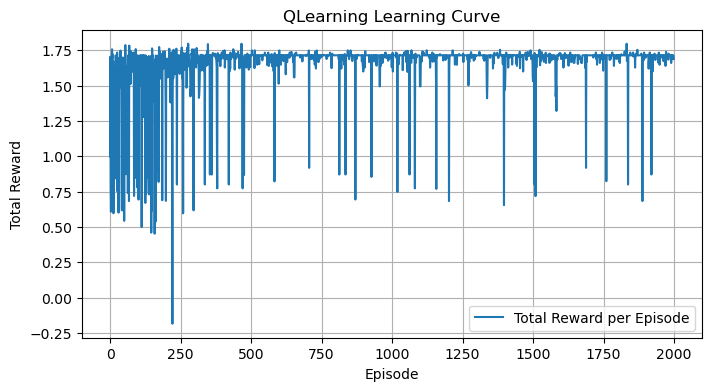

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

import os




from qiskit_aer import AerSimulator                    
from qiskit import transpile, QuantumCircuit

from extractors.von_neumann    import von_neumann
from extractors.elias          import elias
from extractors.universal_hash import universal_hash
from extractors.maurer_wolf    import maurer_wolf_extractor
from utils                     import compute_bias



def generate_quantum_bits(num_bits: int, batch_size: int = 256) -> list[int]:
    backend = AerSimulator()                      # limitless qubits
    qc = QuantumCircuit(batch_size, batch_size)
    qc.h(range(batch_size))
    qc.measure(range(batch_size), range(batch_size))

    shots  = (num_bits + batch_size - 1) // batch_size
    # ↓ no coupling-map check
    result = backend.run(qc, shots=shots).result()

    bits: list[int] = []
    for bitstr, occ in result.get_counts().items():
        bits.extend([int(b) for b in bitstr] * occ)
        if len(bits) >= num_bits:
            break
    return bits[:num_bits]




class ExtractorEnv(gym.Env):
    """
    Gym environment wrapping classical extractors.
    State: [bias, entropy] of the next window
    Action: choose extractor (0=VN,1=Elias,2=Hash,3=Maurer–Wolf)
    Reward: -|out_bias| + alpha*(len(out)/len(window))
    """
    metadata = {'render.modes': []}

    def __init__(self, raw_bits, window_size=256, alpha=0.1):
        super().__init__()
        self.raw_bits         = raw_bits
        self.window_size      = window_size
        self.alpha            = alpha
        self.action_space     = spaces.Discrete(4)
        self.observation_space= spaces.Box(0.0, 1.0, (2,), np.float32)
        self.reset()

    def reset(self):
        self.pos = 0
        return self._next_state()

    def step(self, action):
        start, end = self.pos, min(self.pos + self.window_size, len(self.raw_bits))
        window     = self.raw_bits[start:end]

        # apply chosen extractor
        if   action == 0:
            out = von_neumann(window)
        elif action == 1:
            out = elias(window)
        elif action == 2:
            out = universal_hash(window, seed="seed")
        else:
            rb = self._bits_to_bytes(window)
            ob = maurer_wolf_extractor(rb, seed=b"seed",
                                       output_len=len(rb)//2)
            out = self._bytes_to_bits(ob)

        # compute reward
        out_bias = compute_bias(out)
        reward   = -abs(out_bias) + self.alpha * (len(out)/len(window))

        # advance
        self.pos = end
        done      = (self.pos >= len(self.raw_bits))
        state     = self._next_state()
        return state, reward, done, {'out_bits': out}

    def _next_state(self):
        end    = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[self.pos:end]
        if not window:
            return np.array([0., 0.], dtype=np.float32)

        bias = compute_bias(window)
        p1   = sum(window)/len(window)
        p0   = 1 - p1
        entropy = -(p0*np.log2(p0+1e-9) + p1*np.log2(p1+1e-9))
        return np.array([bias, entropy], dtype=np.float32)

    @staticmethod
    def _bits_to_bytes(bits):
        pad  = (-len(bits)) % 8
        bits = bits + [0]*pad
        out  = bytearray()
        for i in range(0, len(bits), 8):
            byte = 0
            for b in bits[i:i+8]:
                byte = (byte<<1) | b
            out.append(byte)
        return bytes(out)

    @staticmethod
    def _bytes_to_bits(b):
        bits = []
        for byte in b:
            for shift in range(7, -1, -1):
                bits.append((byte>>shift)&1)
        return bits



class QLearningAgent:
    """Simple tabular Q‑learning agent with learning‑curve logging."""
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env             = env
        self.alpha           = alpha
        self.gamma           = gamma
        self.epsilon         = epsilon
        self.q_table         = np.zeros((20, 20, env.action_space.n))
        self.history_rewards = []  

    def discretize(self, state):
        # map continuous [0,1]^2 state to integer grid 0–19
        return tuple((state * 19).astype(int))

    def select_action(self, state):
        s = self.discretize(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[s]))

    def train(self, episodes=1000):
        for ep in range(episodes):
            state, done     = self.env.reset(), False
            total_reward    = 0.0
            while not done:
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)

                s_idx, ns_idx = self.discretize(state), self.discretize(next_state)
                best_next     = np.max(self.q_table[ns_idx])
                idx           = s_idx + (action,)
              
                self.q_table[idx] += self.alpha * (
                    reward + self.gamma * best_next - self.q_table[idx]
                )

                state         = next_state
                total_reward += reward

            # log & decay exploration
            self.history_rewards.append(total_reward)
            self.epsilon = max(0.01, self.epsilon * 0.995)
            if ep % 100 == 0:
                print(f"Episode {ep:4d}  Reward: {total_reward:.2f}  Epsilon: {self.epsilon:.3f}")



# Preparing a biased stream
raw = generate_quantum_bits(20_000) 

# Instantiate env & agent
env   = ExtractorEnv(raw, window_size=512, alpha=0.1)
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, epsilon=0.2)

# Training for 2000 episodes
agent.train(episodes=2000)
print("Training complete.")


plt.figure(figsize=(8,4))
plt.plot(agent.history_rewards, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("QLearning Learning Curve")
plt.grid(True)
plt.legend()
plt.show()

Episode    0  Reward: 0.12  Epsilon: 0.199
Episode  100  Reward: 0.42  Epsilon: 0.121
Episode  200  Reward: 1.02  Epsilon: 0.073
Episode  300  Reward: 1.27  Epsilon: 0.044
Episode  400  Reward: 1.29  Epsilon: 0.027
Episode  500  Reward: 1.27  Epsilon: 0.016
Episode  600  Reward: 1.27  Epsilon: 0.010
Episode  700  Reward: 1.27  Epsilon: 0.010
Episode  800  Reward: 1.25  Epsilon: 0.010
Episode  900  Reward: 1.27  Epsilon: 0.010
Episode 1000  Reward: 1.25  Epsilon: 0.010
Episode 1100  Reward: 1.27  Epsilon: 0.010
Episode 1200  Reward: 1.27  Epsilon: 0.010
Episode 1300  Reward: 1.27  Epsilon: 0.010
Episode 1400  Reward: 1.24  Epsilon: 0.010
Episode 1500  Reward: 1.27  Epsilon: 0.010
Episode 1600  Reward: 1.27  Epsilon: 0.010
Episode 1700  Reward: 1.23  Epsilon: 0.010
Episode 1800  Reward: 1.27  Epsilon: 0.010
Episode 1900  Reward: 1.27  Epsilon: 0.010
Training complete.


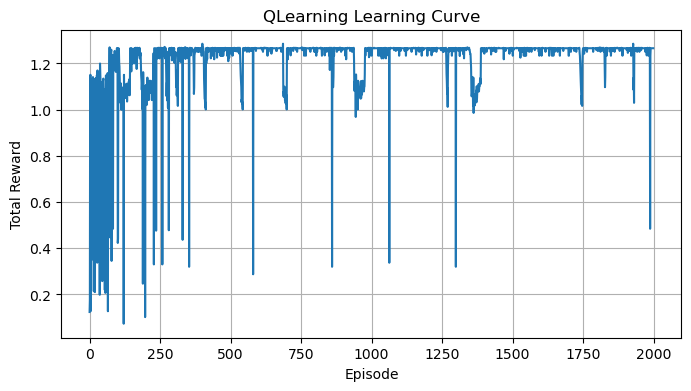

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import requests
import binascii

from qiskit_aer import AerSimulator                   
from qiskit import QuantumCircuit

from extractors.von_neumann    import von_neumann
from extractors.elias          import elias
from extractors.universal_hash import universal_hash
from extractors.maurer_wolf    import maurer_wolf_extractor
from utils                     import compute_bias


def generate_aer_bits(num_bits: int, batch_size: int = 256) -> list[int]:
    """Generate bits via Qiskit AerSimulator."""
    backend = AerSimulator()
    qc = QuantumCircuit(batch_size, batch_size)
    qc.h(range(batch_size)); qc.measure(range(batch_size), range(batch_size))
    shots = (num_bits + batch_size - 1) // batch_size
    result = backend.run(qc, shots=shots).result()
    bits: list[int] = []
    for bitstr, occ in result.get_counts().items():
        bits.extend([int(b) for b in bitstr] * occ)
        if len(bits) >= num_bits: break
    return bits[:num_bits]


def generate_drand_bits(num_bits: int) -> list[int]:
    """
    Fetch bits from the drand public randomness beacon (hex), 512 bits per call.
    """
    bits: list[int] = []
    while len(bits) < num_bits:
        try:
            resp = requests.get("https://api.drand.sh/public/latest")
            resp.raise_for_status()
            data = resp.json().get('randomness', '')
            raw = binascii.unhexlify(data)
            arr = np.frombuffer(raw, dtype=np.uint8)
            bts = np.unpackbits(arr)
            bits.extend(bts.tolist())
        except Exception:
            break
    return bits[:num_bits]


def generate_quantum_bits(num_bits: int, batch_size: int = 256) -> list[int]:
    """
    Try drand beacon for true randomness; if that fails, fallback to AerSimulator.
    """
    bits = generate_drand_bits(num_bits)
    if len(bits) >= num_bits:
        return bits
    return generate_aer_bits(num_bits, batch_size)


class ExtractorEnv(gym.Env):
    """
    Gym environment wrapping classical extractors.
    State: [bias, entropy] of the next window
    Action: choose extractor (0=VN,1=Elias,2=Hash,3=Maurer–Wolf)
    Reward: -|out_bias| + alpha*(len(out)/len(window))
    """
    metadata = {'render.modes': []}

    def __init__(self, raw_bits, window_size=256, alpha=0.1):
        super().__init__()
        self.raw_bits = raw_bits
        self.window_size = window_size
        self.alpha = alpha
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(0.0, 1.0, (2,), np.float32)
        self.reset()

    def reset(self):
        self.pos = 0
        return self._next_state()

    def step(self, action):
        start = self.pos
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[start:end]
        if not window:
            return self._next_state(), 0.0, True, {'out_bits': []}

        # apply chosen extractor
        if action == 0:
            out = von_neumann(window)
        elif action == 1:
            out = elias(window)
        elif action == 2:
            uh = universal_hash(window, seed="seed")
            out = uh if isinstance(uh, list) else self._bytes_to_bits(uh)
        else:
            rb = self._bits_to_bytes(window)
            mw_bytes = maurer_wolf_extractor(rb, seed=b"seed", output_len=len(rb)//2)
            out = self._bytes_to_bits(mw_bytes)

        bias = compute_bias(out)
        reward = -abs(bias) + self.alpha * (len(out) / len(window))

        self.pos = end
        done = (self.pos >= len(self.raw_bits))
        return self._next_state(), reward, done, {'out_bits': out}

    def _next_state(self):
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[self.pos:end]
        if not window:
            return np.array([0.0, 0.0], dtype=np.float32)
        bias = compute_bias(window)
        p1 = sum(window) / len(window)
        p0 = 1 - p1
        entropy = -(p0 * np.log2(p0 + 1e-9) + p1 * np.log2(p1 + 1e-9))
        return np.array([bias, entropy], dtype=np.float32)

    @staticmethod
    def _bits_to_bytes(bits):
        pad = (-len(bits)) % 8
        bits = bits + [0] * pad
        out = bytearray()
        for i in range(0, len(bits), 8):
            byte = 0
            for b in bits[i:i+8]:
                byte = (byte << 1) | b
            out.append(byte)
        return bytes(out)

    @staticmethod
    def _bytes_to_bits(b):
        bits = []
        for byte in b:
            for shift in range(7, -1, -1):
                bits.append((byte >> shift) & 1)
        return bits


class QLearningAgent:
    """Simple tabular Q‑learning agent with learning‑curve logging."""
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((20, 20, env.action_space.n))
        self.history_rewards = []

    def discretize(self, state):
        return tuple((state * 19).astype(int))

    def select_action(self, state):
        s = self.discretize(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[s]))

    def train(self, episodes=2000):
        for ep in range(episodes):
            state, done = self.env.reset(), False
            total_reward = 0.0
            while not done:
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                s_idx = self.discretize(state)
                ns_idx = self.discretize(next_state)
                best_next = np.max(self.q_table[ns_idx])
                idx = s_idx + (action,)
                self.q_table[idx] += self.alpha * (reward + self.gamma * best_next - self.q_table[idx])
                state = next_state
                total_reward += reward
            self.history_rewards.append(total_reward)
            self.epsilon = max(0.01, self.epsilon * 0.995)
            if ep % 100 == 0:
                print(f"Episode {ep:4d}  Reward: {total_reward:.2f}  Epsilon: {self.epsilon:.3f}")


# Run training
raw = generate_quantum_bits(20000, batch_size=256)
env = ExtractorEnv(raw, window_size=512, alpha=0.1)
agent = QLearningAgent(env, alpha=0.1, gamma=0.99, epsilon=0.2)
agent.train(episodes=2000)
print("Training complete.")
plt.figure(figsize=(8,4)); plt.plot(agent.history_rewards); plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("QLearning Learning Curve"); plt.grid(True); plt.show()


Episode    0 | Reward: 1.221 | ε: 0.199
Episode  100 | Reward: 1.582 | ε: 0.121
Episode  200 | Reward: 1.783 | ε: 0.073
Episode  300 | Reward: 2.063 | ε: 0.044
Episode  400 | Reward: 2.331 | ε: 0.027
Episode  500 | Reward: 2.636 | ε: 0.016
Episode  600 | Reward: 2.907 | ε: 0.010
Episode  700 | Reward: 3.135 | ε: 0.010
Episode  800 | Reward: 3.449 | ε: 0.010
Episode  900 | Reward: 3.598 | ε: 0.010
Episode 1000 | Reward: 3.939 | ε: 0.010
Episode 1100 | Reward: 4.207 | ε: 0.010
Episode 1200 | Reward: 4.475 | ε: 0.010
Episode 1300 | Reward: 4.743 | ε: 0.010
Episode 1400 | Reward: 5.011 | ε: 0.010
Episode 1500 | Reward: 5.279 | ε: 0.010
Episode 1600 | Reward: 5.547 | ε: 0.010
Episode 1700 | Reward: 5.813 | ε: 0.010
Episode 1800 | Reward: 6.083 | ε: 0.010
Episode 1900 | Reward: 6.351 | ε: 0.010


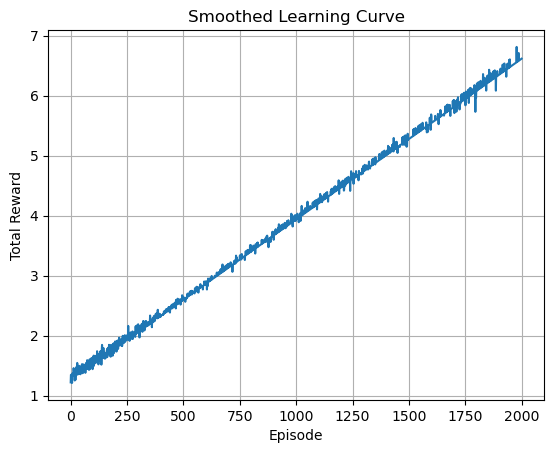

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import requests
import binascii

from qiskit_aer import AerSimulator                   
from qiskit import QuantumCircuit

from extractors.von_neumann    import von_neumann
from extractors.elias          import elias
from extractors.universal_hash import universal_hash
from extractors.maurer_wolf    import maurer_wolf_extractor
from utils                     import compute_bias

def generate_aer_bits(num_bits: int, batch_size: int = 256) -> list[int]:
    """Generate bits via Qiskit AerSimulator."""
    backend = AerSimulator()
    qc = QuantumCircuit(batch_size, batch_size)
    qc.h(range(batch_size)); qc.measure(range(batch_size), range(batch_size))
    shots = (num_bits + batch_size - 1) // batch_size
    result = backend.run(qc, shots=shots).result()
    bits: list[int] = []
    for bitstr, occ in result.get_counts().items():
        bits.extend([int(b) for b in bitstr] * occ)
        if len(bits) >= num_bits: break
    return bits[:num_bits]

def generate_drand_bits(num_bits: int) -> list[int]:
    """Fetch bits from the drand public randomness beacon (hex), 512 bits per call."""
    bits: list[int] = []
    while len(bits) < num_bits:
        try:
            resp = requests.get("https://api.drand.sh/public/latest")
            resp.raise_for_status()
            data = resp.json().get('randomness', '')
            raw = binascii.unhexlify(data)
            arr = np.frombuffer(raw, dtype=np.uint8)
            bits.extend(np.unpackbits(arr).tolist())
        except Exception:
            break
    return bits[:num_bits]

def generate_quantum_bits(num_bits: int, batch_size: int = 256) -> list[int]:
    """
    Try drand beacon for true randomness; if that fails, fallback to AerSimulator.
    """
    bits = generate_drand_bits(num_bits)
    return bits if len(bits) >= num_bits else generate_aer_bits(num_bits, batch_size)

class ExtractorEnv(gym.Env):
    metadata = {'render.modes': []}
    def __init__(self, raw_bits, window_size=256, alpha=0.1):
        super().__init__()
        self.raw_bits = raw_bits
        self.window_size = window_size
        self.alpha = alpha
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(0.0, 1.0, (2,), np.float32)
        self.reset()
    def reset(self):
        self.pos = 0
        return self._next_state()
    def step(self, action):
        start = self.pos
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[start:end]
        if not window:
            return self._next_state(), 0.0, True, {'out_bits': []}
        if action == 0:
            out = von_neumann(window)
        elif action == 1:
            out = elias(window)
        elif action == 2:
            uh = universal_hash(window, seed="seed")
            out = uh if isinstance(uh,list) else self._bytes_to_bits(uh)
        else:
            rb = self._bits_to_bytes(window)
            mwb = maurer_wolf_extractor(rb, seed=b"seed", output_len=len(rb)//2)
            out = self._bytes_to_bits(mwb)
        bias = compute_bias(out)
        rate = len(out) / len(window)
        reward = -abs(bias) + self.alpha * rate  # env-level reward remains for compatibility
        self.pos = end
        done = self.pos >= len(self.raw_bits)
        return self._next_state(), reward, done, {'out_bits': out}
    def _next_state(self):
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[self.pos:end]
        if not window:
            return np.array([0.0,0.0], dtype=np.float32)
        bias = compute_bias(window)
        p1 = sum(window)/len(window); p0 = 1-p1
        ent = -(p0*np.log2(p0+1e-9) + p1*np.log2(p1+1e-9))
        return np.array([bias, ent], dtype=np.float32)
    @staticmethod
    def _bits_to_bytes(bits):
        pad = (-len(bits)) % 8
        bits = bits + [0]*pad
        out=bytearray()
        for i in range(0,len(bits),8):
            byte = sum(b<<(7-j) for j,b in enumerate(bits[i:i+8]))
            out.append(byte)
        return bytes(out)
    @staticmethod
    def _bytes_to_bits(b):
        bits=[]
        for byte in b:
            bits.extend(((byte>>shift)&1) for shift in range(7,-1,-1))
        return bits

class QLearningAgent:
    """Tabular Q‑learning with dynamic reward shaping and finer discretization."""
    def __init__(self, env, lr=1e-3, gamma=0.99, eps=0.2,
                 alpha_start=0.1, alpha_end=0.5, res=50):
        self.env = env
        self.lr = lr
        self.gamma = gamma
        self.epsilon = eps
        self.alpha_start = alpha_start
        self.alpha_end = alpha_end
        self.res = res
        # Q-table: res × res × n_actions
        self.q_table = np.zeros((res, res, env.action_space.n))
        self.history_rewards = []
    def discretize(self, state):
        # state in [0,1]^2 → grid [0,res-1]
        return tuple((state * (self.res-1)).astype(int))
    def select_action(self, state):
        s = self.discretize(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[s]))
    def train(self, episodes=2000):
        for ep in range(episodes):
            # anneal reward alpha
            α = self.alpha_start + (self.alpha_end - self.alpha_start)*(ep/episodes)
            state, done = self.env.reset(), False
            total_reward = 0.0
            while not done:
                action = self.select_action(state)
                next_state, _, done, info = self.env.step(action)
                out = info['out_bits']
                bias = compute_bias(out)
                rate = len(out)/self.env.window_size
                # shaped reward: squared bias penalty + dynamic throughput weight
                reward = -(abs(bias)**2) + α * rate
                # Q-learning update
                s_idx = self.discretize(state)
                ns_idx = self.discretize(next_state)
                best_next = np.max(self.q_table[ns_idx])
                idx = s_idx + (action,)
                self.q_table[idx] += self.lr*(reward + self.gamma*best_next - self.q_table[idx])
                state = next_state
                total_reward += reward
            self.history_rewards.append(total_reward)
            # decay epsilon
            self.epsilon = max(0.01, self.epsilon * 0.995)
            if ep % 100 == 0:
                print(f"Episode {ep:4d} | Reward: {total_reward:.3f} | ε: {self.epsilon:.3f}")
        return self.history_rewards


raw = generate_quantum_bits(20000)
env = ExtractorEnv(raw, window_size=512, alpha=0.1)
agent = QLearningAgent(env,
    lr=1e-3, gamma=0.99, eps=0.2,
    alpha_start=0.1, alpha_end=0.5, res=50)
agent.train(episodes=2000)
plt.plot(agent.history_rewards)
plt.xlabel("Episode"); plt.ylabel("Total Reward")
plt.title("Smoothed Learning Curve"); plt.grid(True); plt.show()


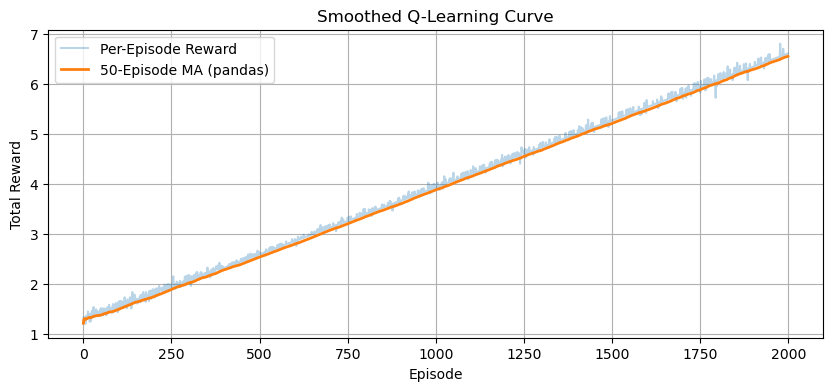

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pull out rewards
rewards  = np.array(agent.history_rewards)
episodes = np.arange(len(rewards))

#  pandas rolling mean 
ma = pd.Series(rewards).rolling(window=50, min_periods=1).mean().to_numpy()

#  pure NumPy convolution
# window = 50
# kernel = np.ones(window) / window
# raw_ma = np.convolve(rewards, kernel, mode='same')
# # correct for the shorter window at the edges
# counts = np.minimum(episodes+1, window)
# ma_np = raw_ma * (window / counts)

plt.figure(figsize=(10,4))
plt.plot(episodes, rewards, alpha=0.3, label="Per-Episode Reward")
plt.plot(episodes, ma,     lw=2,   label="50-Episode MA (pandas)")
# plt.plot(episodes, ma_np,  lw=1, linestyle='--', label="50-Episode MA (numpy)")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Smoothed Q-Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


In [87]:
#updated extractor comparison

import numpy as np
import pandas as pd

#  Rebuild the env and force greedy policy 

env = ExtractorEnv(raw, window_size=512, alpha=0.1)

# Temporarily disable exploration
old_eps = agent.epsilon
agent.epsilon = 0.0

# Collect all bits emitted by the Meta-RL policy
state, done = env.reset(), False
meta_out    = []
while not done:
    # Greedy action
    a, = np.argmax(agent.q_table[agent.discretize(state)]),
    state, _, done, info = env.step(a)
    meta_out.extend(info['out_bits'])

# Restore exploration rate (just in case)
agent.epsilon = old_eps

# Run each classical extractor on the same raw stream 
vn_out     = von_neumann(raw)
el_out     = elias(raw)
uh_out     = universal_hash(raw, seed="seed")
rb         = ExtractorEnv._bits_to_bytes(raw)
mw_bytes   = maurer_wolf_extractor(rb, seed=b"seed", output_len=len(rb)//2)
mw_out     = ExtractorEnv._bytes_to_bits(mw_bytes)

#  Build a DataFrame of Bias & Output Length 
results = {
    'Meta-RL':    meta_out,
    'VonNeumann': vn_out,
    'Elias':      el_out,
    'UHash':      uh_out,
    'MaurerWolf': mw_out,
}

data = []
for name, out_bits in results.items():
    data.append({
        'Extractor': name,
        'Bias':      compute_bias(out_bits),
        'OutLen':    len(out_bits)
    })

df = pd.DataFrame(data).set_index('Extractor')
df


,Bias,OutLen
Extractor,,
Meta-RL,0.026822,6860
VonNeumann,0.005316,5173
Elias,0.034362,8105
UHash,0.011719,256
MaurerWolf,0.003100,10000


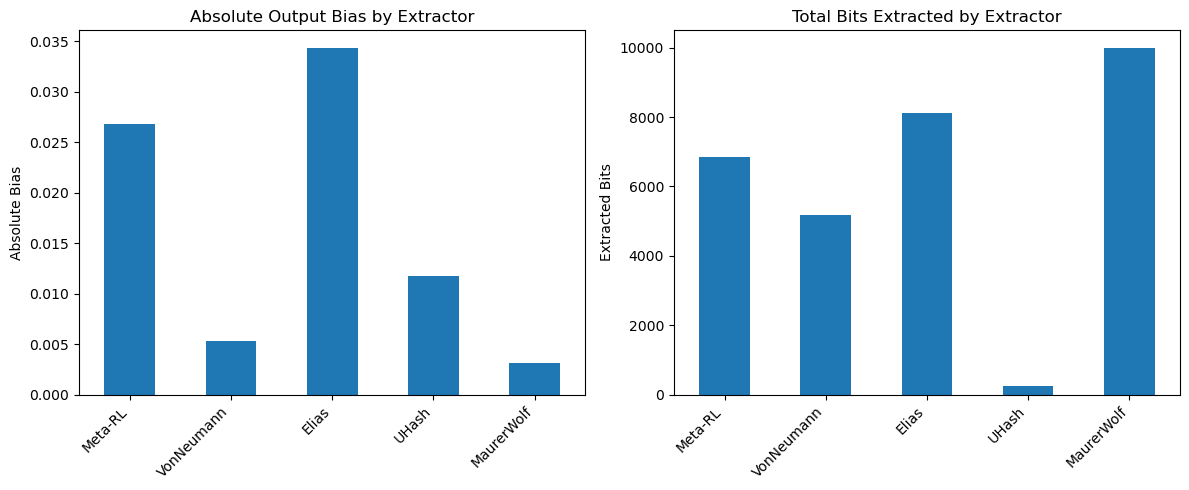

In [88]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


df['Bias'].plot.bar(ax=ax1)
ax1.set_title('Absolute Output Bias by Extractor')
ax1.set_ylabel('Absolute Bias')
ax1.set_xlabel('')
ax1.set_xticklabels(df.index, rotation=45, ha='right')


df['OutLen'].plot.bar(ax=ax2)
ax2.set_title('Total Bits Extracted by Extractor')
ax2.set_ylabel('Extracted Bits')
ax2.set_xlabel('')
ax2.set_xticklabels(df.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()


Episode    0 | Reward: 1.372 | ε: 0.199
Episode  100 | Reward: 1.712 | ε: 0.121
Episode  200 | Reward: 2.011 | ε: 0.073
Episode  300 | Reward: 2.302 | ε: 0.044
Episode  400 | Reward: 2.568 | ε: 0.027
Episode  500 | Reward: 2.899 | ε: 0.016
Episode  600 | Reward: 3.160 | ε: 0.010
Episode  700 | Reward: 3.450 | ε: 0.010
Episode  800 | Reward: 3.815 | ε: 0.010
Episode  900 | Reward: 4.071 | ε: 0.010
Episode 1000 | Reward: 4.321 | ε: 0.010
Episode 1100 | Reward: 4.611 | ε: 0.010
Episode 1200 | Reward: 4.902 | ε: 0.010
Episode 1300 | Reward: 5.192 | ε: 0.010
Episode 1400 | Reward: 5.482 | ε: 0.010
Episode 1500 | Reward: 5.772 | ε: 0.010
Episode 1600 | Reward: 6.063 | ε: 0.010
Episode 1700 | Reward: 6.416 | ε: 0.010
Episode 1800 | Reward: 6.774 | ε: 0.010
Episode 1900 | Reward: 6.934 | ε: 0.010
Extractor    | Bias before | Bias after |  OutLen
--------------------------------------------------
Meta-RL      |       0.035 |      0.027 |    7431
VN           |       0.035 |      0.008 |    5847

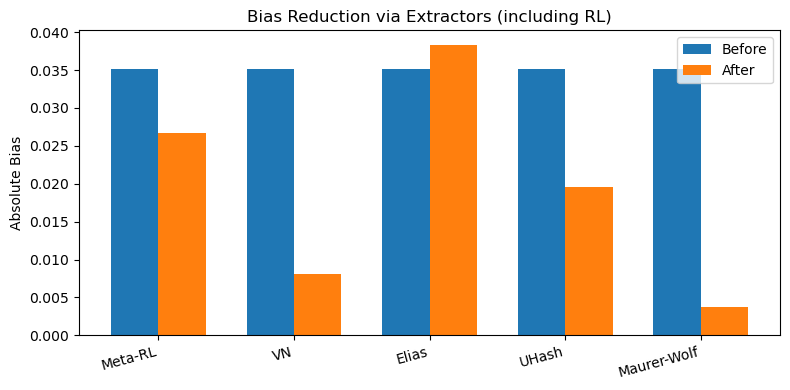

In [ ]:

"""
compare_extractors.py
Bias comparison and plotting for classical extractors plus RL meta‐policy.
"""

import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import requests, binascii

from extractors.von_neumann    import von_neumann
from extractors.elias          import elias
from extractors.universal_hash import universal_hash
from extractors.maurer_wolf    import maurer_wolf_extractor
from utils                     import compute_bias

# Qiskit-Aer imports for fallback quantum bits
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit

def main():
    # Fetch a 20 000-bit raw stream (drand → Aer fallback)
    raw_bits = generate_quantum_bits(20_000, batch_size=256)

    # Build the environment and RL agent (match your new signature)
    env = ExtractorEnv(raw_bits, window_size=512, alpha=0.1)
    agent = QLearningAgent(
        env,
        lr=1e-3,        # learning rate
        gamma=0.99,     # discount factor
        eps=0.2,        # initial ε
        alpha_start=0.1,# reward‐shaping α at start
        alpha_end=0.5,  # reward‐shaping α at end
        res=50          # 50×50 discretization grid
    )
    agent.train(episodes=2000)

    # Greedy rollout of the trained policy to collect RL output bits
    state, done = env.reset(), False
    agent.epsilon = 0.0
    meta_out = []
    while not done:
        a = int(np.argmax(agent.q_table[agent.discretize(state)]))
        state, _, done, info = env.step(a)
        meta_out.extend(info['out_bits'])

    # Apply each classical extractor to the same raw_bits
    results = {}

    # Meta‐RL
    results['Meta-RL'] = (
        compute_bias(raw_bits),
        compute_bias(meta_out),
        len(meta_out)
    )

    # Von Neumann
    vn_out = von_neumann(raw_bits)
    results['VN'] = (
        compute_bias(raw_bits),
        compute_bias(vn_out),
        len(vn_out)
    )

    # Elias
    el_out = elias(raw_bits)
    results['Elias'] = (
        compute_bias(raw_bits),
        compute_bias(el_out),
        len(el_out)
    )

    # Universal Hash
    uh = universal_hash(raw_bits, seed="seed")
    if not isinstance(uh, list):
        uh = ExtractorEnv._bytes_to_bits(uh)
    results['UHash'] = (
        compute_bias(raw_bits),
        compute_bias(uh),
        len(uh)
    )

    # Maurer–Wolf
    raw_bytes = ExtractorEnv._bits_to_bytes(raw_bits)
    mwb       = maurer_wolf_extractor(
        raw_bytes, seed=b"seed", output_len=len(raw_bytes)//2
    )
    mw_bits = ExtractorEnv._bytes_to_bits(mwb)
    results['Maurer-Wolf'] = (
        compute_bias(raw_bits),
        compute_bias(mw_bits),
        len(mw_bits)
    )

    # Print summary table
    print(f"{'Extractor':<12} | {'Bias before':>11} | {'Bias after':>10} | {'OutLen':>7}")
    print("-"*50)
    for name, (b0, b1, L) in results.items():
        print(f"{name:<12} | {b0:11.3f} | {b1:10.3f} | {L:7d}")

    # Plot bias reduction
    labels = list(results.keys())
    before = [v[0] for v in results.values()]
    after  = [v[1] for v in results.values()]
    x = np.arange(len(labels))
    w = 0.35

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - w/2, before, width=w, label="Before")
    ax.bar(x + w/2, after,  width=w, label="After")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15, ha="right")
    ax.set_ylabel("Absolute Bias")
    ax.set_title("Bias Reduction via Extractors (including RL)")
    ax.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()





Episode    0 | Reward: -7.989 | ε: 0.199
Episode  250 | Reward: -5.769 | ε: 0.094
Episode  500 | Reward: -4.104 | ε: 0.044
Episode  750 | Reward: -4.880 | ε: 0.021
Episode 1000 | Reward: -4.151 | ε: 0.010
Episode 1250 | Reward: -3.334 | ε: 0.010
Episode 1500 | Reward: -3.684 | ε: 0.010
Episode 1750 | Reward: -1.289 | ε: 0.010
Episode 2000 | Reward: -2.153 | ε: 0.010
Episode 2250 | Reward: -2.488 | ε: 0.010
Episode 2500 | Reward: -1.523 | ε: 0.010
Episode 2750 | Reward: -3.395 | ε: 0.010
Episode 3000 | Reward: -2.732 | ε: 0.010
Episode 3250 | Reward: -2.589 | ε: 0.010
Episode 3500 | Reward: -2.405 | ε: 0.010
Episode 3750 | Reward: -2.381 | ε: 0.010
Episode 4000 | Reward: -1.460 | ε: 0.010
Episode 4250 | Reward: -1.663 | ε: 0.010
Episode 4500 | Reward: -0.820 | ε: 0.010
Episode 4750 | Reward: -0.625 | ε: 0.010


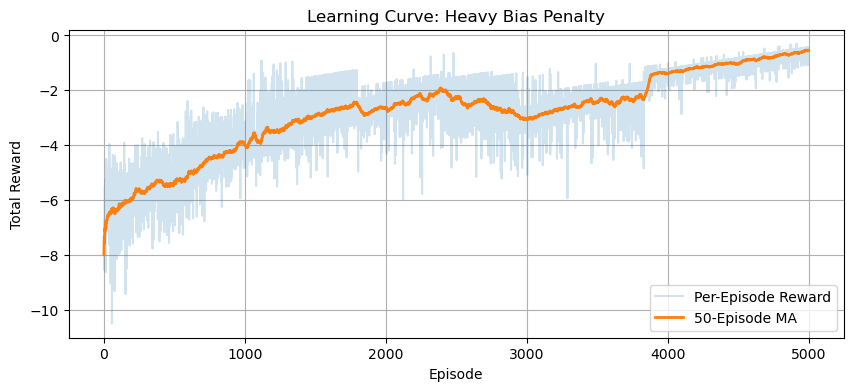

Extractor    | Bias before | Bias after |  OutLen
--------------------------------------------------
Meta-RL      |       0.000 |      0.006 |   10000
VonNeumann   |       0.000 |      0.044 |    5361
Elias        |       0.000 |      0.010 |    7686
UHash        |       0.000 |      0.008 |     256
Maurer-Wolf  |       0.000 |      0.005 |   10000
Episode    0 | Reward: -4.336 | ε: 0.010
Episode  250 | Reward: -4.419 | ε: 0.010
Episode  500 | Reward: -4.876 | ε: 0.010
Episode  750 | Reward: -4.366 | ε: 0.010
Episode 1000 | Reward: -3.594 | ε: 0.010
Episode 1250 | Reward: -3.186 | ε: 0.010
Episode 1500 | Reward: -2.539 | ε: 0.010
Episode 1750 | Reward: -4.006 | ε: 0.010
Episode 2000 | Reward: -4.009 | ε: 0.010
Episode 2250 | Reward: -3.107 | ε: 0.010
Episode 2500 | Reward: -2.578 | ε: 0.010
Episode 2750 | Reward: -4.606 | ε: 0.010
Episode 3000 | Reward: -1.992 | ε: 0.010
Episode 3250 | Reward: -1.797 | ε: 0.010
Episode 3500 | Reward: -1.946 | ε: 0.010
Episode 3750 | Reward: -1.406 | ε:

         154402105 function calls in 58.811 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   58.811   58.811 {built-in method builtins.exec}
        1    0.000    0.000   58.810   58.810 <string>:1(<module>)
        1    1.282    1.282   58.810   58.810 2618429738.py:150(train)
   200000    1.043    0.000   49.690    0.000 2618429738.py:66(step)
   149189   24.778    0.000   30.703    0.000 universal_hash.py:9(universal_hash)
   600000    0.566    0.000   14.064    0.000 metrics.py:9(compute_bias)
   600000    1.188    0.000   13.347    0.000 fromnumeric.py:3385(mean)
   600000    1.526    0.000   12.159    0.000 _methods.py:101(_mean)
   600000    8.114    0.000    8.114    0.000 {built-in method numpy.asanyarray}
   205000    0.935    0.000    7.946    0.000 2618429738.py:91(_next_state)
 78578702    3.381    0.000    3.381    0.000 {built-in method builtins.len}
 49612937    2.364    0.000 

In [ ]:
# Full updated code with fix for reward calculation in ExtractorEnv:

import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import requests
import binascii

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit

from extractors.von_neumann    import von_neumann
from extractors.elias          import elias
from extractors.universal_hash import universal_hash
from extractors.maurer_wolf    import maurer_wolf_extractor
from utils                     import compute_bias

def generate_aer_bits(num_bits: int, batch_size: int = 256) -> list[int]:
    """Generate bits via Qiskit AerSimulator."""
    backend = AerSimulator()
    qc = QuantumCircuit(batch_size, batch_size)
    qc.h(range(batch_size)); qc.measure(range(batch_size), range(batch_size))
    shots = (num_bits + batch_size - 1) // batch_size
    result = backend.run(qc, shots=shots).result()
    bits: list[int] = []
    for bitstr, occ in result.get_counts().items():
        bits.extend([int(b) for b in bitstr] * occ)
        if len(bits) >= num_bits: break
    return bits[:num_bits]

def generate_drand_bits(num_bits: int) -> list[int]:
    """Fetch bits from the drand public randomness beacon."""
    bits: list[int] = []
    while len(bits) < num_bits:
        try:
            resp = requests.get("https://api.drand.sh/public/latest")
            resp.raise_for_status()
            data = resp.json().get('randomness', '')
            raw = binascii.unhexlify(data)
            arr = np.frombuffer(raw, dtype=np.uint8)
            bits.extend(np.unpackbits(arr).tolist())
        except Exception:
            break
    return bits[:num_bits]

def generate_quantum_bits(num_bits: int, batch_size: int = 256) -> list[int]:
    """Try drand beacon then fallback to AerSimulator."""
    bits = generate_drand_bits(num_bits)
    return bits if len(bits) >= num_bits else generate_aer_bits(num_bits, batch_size)

class ExtractorEnv(gym.Env):
    """Gym environment wrapping classical extractors."""
    metadata = {'render.modes': []}
    def __init__(self, raw_bits, window_size=256, alpha=0.0):
        super().__init__()
        self.raw_bits = raw_bits
        self.window_size = window_size
        self.alpha = alpha
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(0.0, 1.0, (2,), np.float32)
        self.reset()
    def reset(self):
        self.pos = 0
        return self._next_state()
    def step(self, action):
        start = self.pos
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[start:end]
        if not window:
            return self._next_state(), 0.0, True, {'out_bits': []}
        # apply extractor
        if action == 0:
            out = von_neumann(window)
        elif action == 1:
            out = elias(window)
        elif action == 2:
            uh = universal_hash(window, seed="seed")
            out = uh if isinstance(uh, list) else self._bytes_to_bits(uh)
        else:
            rb = self._bits_to_bytes(window)
            mwb = maurer_wolf_extractor(rb, seed=b"seed", output_len=len(rb)//2)
            out = self._bytes_to_bits(mwb)
        # compute env reward (placeholder; agent uses its own)
        bias = compute_bias(out)
        rate = len(out) / len(window)
        reward = -abs(bias) + self.alpha * rate
        self.pos = end
        done = self.pos >= len(self.raw_bits)
        return self._next_state(), reward, done, {'out_bits': out}
    def _next_state(self):
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[self.pos:end]
        if not window:
            return np.array([0.0, 0.0], dtype=np.float32)
        bias = compute_bias(window)
        p1 = sum(window) / len(window); p0 = 1 - p1
        entropy = -(p0 * np.log2(p0 + 1e-9) + p1 * np.log2(p1 + 1e-9))
        return np.array([bias, entropy], dtype=np.float32)
    @staticmethod
    def _bits_to_bytes(bits):
        pad = (-len(bits)) % 8
        bits = bits + [0] * pad
        out = bytearray()
        for i in range(0, len(bits), 8):
            byte = 0
            for b in bits[i:i+8]:
                byte = (byte << 1) | b
            out.append(byte)
        return bytes(out)
    @staticmethod
    def _bytes_to_bits(b):
        bits = []
        for byte in b:
            for shift in range(7, -1, -1):
                bits.append((byte >> shift) & 1)
        return bits

class QLearningAgent:
    """Tabular Q-learning with heavy bias penalty and fine discretization."""
    def __init__(self,
                 env,
                 lr=5e-4,
                 gamma=0.99,
                 eps=0.2,
                 bias_coef=10.0,
                 alpha_start=0.0,
                 alpha_end=0.2,
                 res=100):
        self.env = env
        self.lr = lr
        self.gamma = gamma
        self.epsilon = eps
        self.bias_coef = bias_coef
        self.alpha_start = alpha_start
        self.alpha_end = alpha_end
        self.res = res
        self.q_table = np.zeros((res, res, env.action_space.n))
        self.history_rewards = []

    def discretize(self, state):
        return tuple((state * (self.res - 1)).astype(int))

    def select_action(self, state):
        s = self.discretize(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[s]))

    def train(self, episodes=5000):
        for ep in range(episodes):
            α = self.alpha_start + (self.alpha_end - self.alpha_start) * (ep / episodes)
            state, done = self.env.reset(), False
            total_reward = 0.0
            while not done:
                a = self.select_action(state)
                nxt, _, done, info = self.env.step(a)
                out = info['out_bits']
                bias = compute_bias(out)
                rate = len(out) / self.env.window_size
                reward = -self.bias_coef * abs(bias) + α * rate
                s_idx = self.discretize(state)
                ns_idx = self.discretize(nxt)
                best_next = np.max(self.q_table[ns_idx])
                idx = s_idx + (a,)
                self.q_table[idx] += self.lr * (reward + self.gamma * best_next - self.q_table[idx])
                state = nxt
                total_reward += reward
            self.history_rewards.append(total_reward)
            self.epsilon = max(0.01, self.epsilon * 0.997)
            if ep % 250 == 0:
                print(f"Episode {ep:4d} | Reward: {total_reward:.3f} | ε: {self.epsilon:.3f}")
        return self.history_rewards

# Run training 
raw = generate_quantum_bits(20000, batch_size=256)
env = ExtractorEnv(raw, window_size=512, alpha=0.0)
agent = QLearningAgent(env,
                       lr=5e-4,
                       gamma=0.99,
                       eps=0.2,
                       bias_coef=10.0,
                       alpha_start=0.0,
                       alpha_end=0.2,
                       res=100)
agent.train(episodes=5000)

# Plot learning curve 
import pandas as pd
rewards = np.array(agent.history_rewards)
ma = pd.Series(rewards).rolling(50, min_periods=1).mean()
plt.figure(figsize=(10,4))
plt.plot(rewards, alpha=0.2, label="Per-Episode Reward")
plt.plot(ma, lw=2, label="50-Episode MA")
plt.xlabel("Episode"); plt.ylabel("Total Reward")
plt.title("Learning Curve: Heavy Bias Penalty")
plt.legend(); plt.grid(True); plt.show()

# Evaluate RL vs Classical 
state, done = env.reset(), False
agent.epsilon = 0.0
meta_out = []
while not done:
    a = int(np.argmax(agent.q_table[agent.discretize(state)]))
    state, _, done, info = env.step(a)
    meta_out.extend(info['out_bits'])

vn_out = von_neumann(raw)
el_out = elias(raw)
uh = universal_hash(raw, seed="seed")
uh_out = uh if isinstance(uh, list) else env._bytes_to_bits(uh)
raw_bytes = env._bits_to_bytes(raw)
mwb = maurer_wolf_extractor(raw_bytes, seed=b"seed", output_len=len(raw_bytes)//2)
mw_out = env._bytes_to_bits(mwb)

streams = {
    'Meta-RL':     meta_out,
    'VonNeumann':  vn_out,
    'Elias':       el_out,
    'UHash':       uh_out,
    'Maurer-Wolf': mw_out,
}
b0 = compute_bias(raw)
print(f"{'Extractor':<12} | {'Bias before':>11} | {'Bias after':>10} | {'OutLen':>7}")
print("-"*50)
for name, out in streams.items():
    print(f"{name:<12} | {b0:11.3f} | {compute_bias(out):10.3f} | {len(out):7d}")

%prun -s cumulative agent.train(episodes=5000)




Episode    0 | Reward: -11.145 | ε: 0.199
Episode  250 | Reward: -8.207 | ε: 0.094
Episode  500 | Reward: -6.582 | ε: 0.044
Episode  750 | Reward: -6.933 | ε: 0.021
Episode 1000 | Reward: -7.356 | ε: 0.010
Episode 1250 | Reward: -6.210 | ε: 0.010
Episode 1500 | Reward: -6.020 | ε: 0.010
Episode 1750 | Reward: -5.830 | ε: 0.010
Episode 2000 | Reward: -5.132 | ε: 0.010
Episode 2250 | Reward: -7.701 | ε: 0.010
Episode 2500 | Reward: -5.333 | ε: 0.010
Episode 2750 | Reward: -3.849 | ε: 0.010
Episode 3000 | Reward: -3.654 | ε: 0.010
Episode 3250 | Reward: -2.632 | ε: 0.010
Episode 3500 | Reward: -3.307 | ε: 0.010
Episode 3750 | Reward: -2.190 | ε: 0.010
Episode 4000 | Reward: -1.683 | ε: 0.010
Episode 4250 | Reward: -1.483 | ε: 0.010
Episode 4500 | Reward: -1.283 | ε: 0.010
Episode 4750 | Reward: -1.083 | ε: 0.010


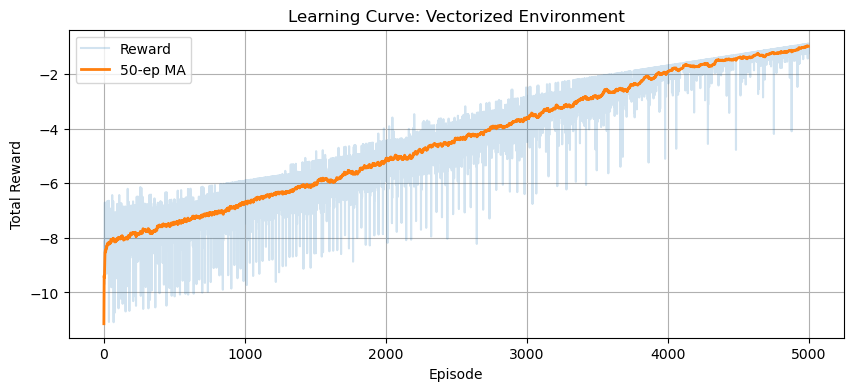

Episode    0 | Reward: -4.883 | ε: 0.010
Episode  250 | Reward: -6.478 | ε: 0.010
Episode  500 | Reward: -7.114 | ε: 0.010
Episode  750 | Reward: -5.795 | ε: 0.010
Episode 1000 | Reward: -6.246 | ε: 0.010
Episode 1250 | Reward: -4.731 | ε: 0.010
Episode 1500 | Reward: -4.876 | ε: 0.010
Episode 1750 | Reward: -4.682 | ε: 0.010
Episode 2000 | Reward: -4.134 | ε: 0.010
Episode 2250 | Reward: -4.240 | ε: 0.010
Episode 2500 | Reward: -3.396 | ε: 0.010
Episode 2750 | Reward: -3.042 | ε: 0.010
Episode 3000 | Reward: -2.831 | ε: 0.010
Episode 3250 | Reward: -2.283 | ε: 0.010
Episode 3500 | Reward: -2.083 | ε: 0.010
Episode 3750 | Reward: -1.883 | ε: 0.010
Episode 4000 | Reward: -2.210 | ε: 0.010
Episode 4250 | Reward: -1.483 | ε: 0.010
Episode 4500 | Reward: -1.283 | ε: 0.010
Episode 4750 | Reward: -1.440 | ε: 0.010
 

         16834968 function calls in 9.178 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    9.178    9.178 {built-in method builtins.exec}
        1    0.000    0.000    9.178    9.178 <string>:1(<module>)
        1    0.592    0.592    9.178    9.178 3184531930.py:136(train)
   200000    0.696    0.000    5.308    0.000 3184531930.py:78(step)
   600000    0.143    0.000    2.707    0.000 {method 'mean' of 'numpy.ndarray' objects}
   600000    0.950    0.000    2.564    0.000 _methods.py:101(_mean)
   400000    0.160    0.000    1.978    0.000 3184531930.py:59(compute_bias_fast)
   205000    0.521    0.000    1.632    0.000 3184531930.py:100(_next_state)
   600000    1.016    0.000    1.292    0.000 3184531930.py:127(discretize)
   200000    0.252    0.000    1.122    0.000 3184531930.py:130(select_action)
     5939    0.899    0.000    1.052    0.000 elias.py:4(elias)
   800000    0.954    0.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import requests
import binascii
import hashlib

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit

from extractors.von_neumann    import von_neumann
from extractors.elias          import elias
# we’ll replace universal_hash with vectorized version
from extractors.maurer_wolf    import maurer_wolf_extractor
from utils                     import compute_bias  # still used for logging

#  Bit‐generation (drand → Aer) returning NumPy array

def generate_aer_bits(num_bits: int, batch_size: int = 256) -> np.ndarray:
    backend = AerSimulator()
    qc = QuantumCircuit(batch_size, batch_size)
    qc.h(range(batch_size)); qc.measure(range(batch_size), range(batch_size))
    shots = (num_bits + batch_size - 1) // batch_size
    result = backend.run(qc, shots=shots).result()
    bits = []
    for bitstr, occ in result.get_counts().items():
        bits.extend([int(b) for b in bitstr] * occ)
        if len(bits) >= num_bits:
            break
    return np.array(bits[:num_bits], dtype=np.uint8)

def generate_drand_bits(num_bits: int) -> np.ndarray:
    bits = []
    while len(bits) < num_bits:
        try:
            resp = requests.get("https://api.drand.sh/public/latest")
            resp.raise_for_status()
            data = resp.json().get('randomness','')
            raw = binascii.unhexlify(data)
            arr = np.frombuffer(raw, dtype=np.uint8)
            bits.extend(np.unpackbits(arr).tolist())
        except Exception:
            break
    return np.array(bits[:num_bits], dtype=np.uint8)

def generate_quantum_bits(num_bits: int, batch_size: int = 256) -> np.ndarray:
    drand_bits = generate_drand_bits(num_bits)
    return drand_bits if len(drand_bits) >= num_bits else generate_aer_bits(num_bits, batch_size)

#Fast helpers

def universal_hash_fast(bits: np.ndarray, seed: str = "seed") -> np.ndarray:
    """Vectorized universal hash via SHA256 + unpackbits."""
    packed = np.packbits(bits)
    digest = hashlib.sha256(seed.encode() + packed.tobytes()).digest()
    return np.unpackbits(np.frombuffer(digest, dtype=np.uint8))

def compute_bias_fast(bits: np.ndarray) -> float:
    """Absolute bias using NumPy mean."""
    return abs(bits.mean() - 0.5)

#  Environment 

class ExtractorEnv(gym.Env):
    metadata = {'render.modes': []}
    def __init__(self, raw_bits: np.ndarray, window_size=256, alpha=0.1):
        super().__init__()
        self.raw_bits = raw_bits
        self.window_size = window_size
        self.alpha = alpha
        self.action_space     = spaces.Discrete(4)
        self.observation_space= spaces.Box(0.0,1.0,(2,),np.float32)
        self.reset()
    def reset(self):
        self.pos = 0
        return self._next_state()
    def step(self, action):
        start = self.pos
        end   = min(start + self.window_size, len(self.raw_bits))
        window = self.raw_bits[start:end]
        if window.size == 0:
            return self._next_state(), 0.0, True, {'out_bits': np.empty(0,dtype=np.uint8)}
        if action == 0:
            out = np.array(von_neumann(window.tolist()), dtype=np.uint8)
        elif action == 1:
            out = np.array(elias(window.tolist()), dtype=np.uint8)
        elif action == 2:
            out = universal_hash_fast(window)
        else:
            packed = np.packbits(window)
            mwb    = maurer_wolf_extractor(packed.tobytes(), seed=b"seed", output_len=packed.size//2)
            out    = np.unpackbits(np.frombuffer(mwb, dtype=np.uint8))
        bias   = compute_bias_fast(out)
        rate   = out.size / window.size
        reward = -bias**2 + self.alpha * rate
        self.pos = end
        done = (self.pos >= len(self.raw_bits))
        return self._next_state(), reward, done, {'out_bits': out}
    def _next_state(self):
        end = min(self.pos + self.window_size, len(self.raw_bits))
        window = self.raw_bits[self.pos:end]
        if window.size == 0:
            return np.array([0.,0.], dtype=np.float32)
        p1 = window.mean(); p0 = 1 - p1
        bias = abs(p1 - 0.5)
        entropy = -(p0*np.log2(p0+1e-9) + p1*np.log2(p1+1e-9))
        return np.array([bias, entropy], dtype=np.float32)

# Agent

class QLearningAgent:
    """Tabular Q-learning with heavy bias penalty and fine discretization."""
    def __init__(self, env, lr=5e-4, gamma=0.99, eps=0.2,
                 bias_coef=10.0, alpha_start=0.0, alpha_end=0.2, res=100):
        self.env = env
        self.lr = lr
        self.gamma = gamma
        self.epsilon = eps
        self.bias_coef = bias_coef
        self.alpha_start = alpha_start
        self.alpha_end = alpha_end
        self.res = res
        self.q_table = np.zeros((res, res, env.action_space.n))
        self.history_rewards = []

    def discretize(self, state):
        return tuple((state * (self.res - 1)).astype(int))

    def select_action(self, state):
        s = self.discretize(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[s]))

    def train(self, episodes=5000):
        for ep in range(episodes):
            α = self.alpha_start + (self.alpha_end - self.alpha_start)*(ep/episodes)
            state, done = self.env.reset(), False
            total_reward = 0.0
            while not done:
                a = self.select_action(state)
                nxt, _, done, info = self.env.step(a)
                out = info['out_bits']
                bias = compute_bias_fast(out)
                rate = out.size / self.env.window_size
                reward = -self.bias_coef * bias + α * rate
                s_idx = self.discretize(state)
                ns_idx= self.discretize(nxt)
                bestn = self.q_table[ns_idx].max()
                self.q_table[s_idx + (a,)] += self.lr * (reward + self.gamma*bestn - self.q_table[s_idx + (a,)])
                state = nxt
                total_reward += reward
            self.history_rewards.append(total_reward)
            self.epsilon = max(0.01, self.epsilon * 0.997)
            if ep % 250 == 0:
                print(f"Episode {ep:4d} | Reward: {total_reward:.3f} | ε: {self.epsilon:.3f}")
        return self.history_rewards



raw = generate_quantum_bits(20000, batch_size=256)
env = ExtractorEnv(raw, window_size=512, alpha=0.0)
agent = QLearningAgent(env)
agent.train(episodes=5000)

rewards = np.array(agent.history_rewards)
import pandas as pd
ma = pd.Series(rewards).rolling(50, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(rewards, alpha=0.2, label="Reward")
plt.plot(ma,     lw=2,   label="50-ep MA")
plt.xlabel("Episode"); plt.ylabel("Total Reward")
plt.title("Learning Curve: Vectorized Environment")
plt.legend(); plt.grid(True); plt.show()

%prun -s cumulative agent.train(episodes=5000)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nistrng import (
    SP800_22R1A_BATTERY,
    check_eligibility_all_battery,
    run_all_battery
)

def nist_pass_rate(bits) -> tuple[int,int,float]:
    """
    Run SP800-22 on `bits`. Returns (passed, total, pass_rate).
    """
    # Ensure numpy array
    seq = np.array(bits, dtype=np.int8)

    # Eligibility map
    eligible_map = check_eligibility_all_battery(seq, SP800_22R1A_BATTERY)
    n_eligible   = sum(1 for v in eligible_map.values() if bool(v))
    if n_eligible == 0:
        return 0, 0, np.nan

    # Run the full battery boolean is positional, not named
    results = run_all_battery(seq, eligible_map, False)

    #Count passes
    passed = sum(1 for res, _ in results if res.passed)
    total  = len(results)
    return passed, total, passed/total


streams = {
    'Raw-Aer (1e6)': raw_million,
    'Meta-RL':       meta_out_m,
    'VonNeumann':    vn_out_m,
    'Elias':         el_out_m,
    'UHash':         uh_out_m,
    'MaurerWolf':    mw_out_m,
}

rows = []
for name, bits in streams.items():
    p, t, rate = nist_pass_rate(bits)
    rows.append({
        'Stream':    name,
        'BitLen':    len(bits),
        'Eligible':  t,
        'Passed':    p,
        'PassRate%': rate * 100 if t>0 else np.nan
    })

df_nist = pd.DataFrame(rows).set_index('Stream')
print(df_nist[['BitLen','Eligible','Passed','PassRate%']])


                BitLen  Eligible  Passed  PassRate%
Stream                                             
Raw-Aer (1e6)  1000000        14       6  42.857143
Meta-RL         491144        13       7  53.846154
VonNeumann      250282        12       5  41.666667
Elias           459696        12       4  33.333333
UHash              256        11       9  81.818182
MaurerWolf      500000        13       8  61.538462


,BitLen,Eligible,Passed,PassRate%
Stream,,,,
Raw-Aer (1e6),1000000,14,6,42.857143
Meta-RL,491144,13,7,53.846154
VonNeumann,250282,12,6,50.000000
Elias,459696,12,4,33.333333
UHash,256,11,9,81.818182
MaurerWolf,500000,13,8,61.538462


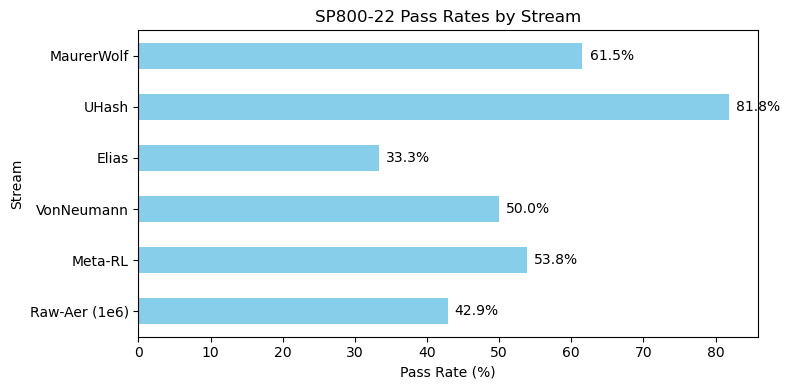

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display

# Display the DataFrame as an interactive Jupyter table
display(df_nist[['BitLen','Eligible','Passed','PassRate%']])


plt.figure(figsize=(8, 4))
ax = df_nist['PassRate%'].plot.barh(color='skyblue')
for idx, val in enumerate(df_nist['PassRate%']):
    ax.text(val + 1, idx, f"{val:.1f}%", va='center')
ax.set_xlabel('Pass Rate (%)')
ax.set_title('SP800-22 Pass Rates by Stream')
plt.tight_layout()
plt.show()


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load saved token & connect
service = QiskitRuntimeService(channel="ibm_quantum")

# All backends available:
all_backends = service.backends()
print("All available backends:")
for b in all_backends:
    print(" ", b.name)


real_ops = service.backends(simulator=False, operational=True)
print("\nOperational hardware backends:")
for b in real_ops:
    print(" ", b.name)

# Only hosted simulators:
sims = service.backends(simulator=True, operational=True)
print("\nHosted simulator backends:")
for b in sims:
    print(" ", b.name)


C:\Users\ereci\AppData\Local\Temp\ipykernel_893444\4206724769.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


All available backends:
  ibm_brisbane
  ibm_sherbrooke

Operational hardware backends:
  ibm_brisbane
  ibm_sherbrooke

Hosted simulator backends:


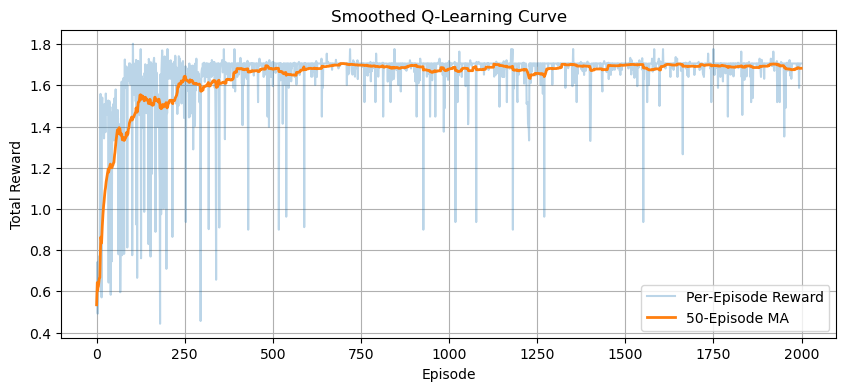

In [33]:
import pandas as pd

rewards = agent.history_rewards
episodes = np.arange(len(rewards))

# compute 50‑episode moving average
ma = pd.Series(rewards).rolling(window=50, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(episodes, rewards, alpha=0.3, label="Per‑Episode Reward")
plt.plot(episodes, ma,    lw=2,   label="50‑Episode MA")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Smoothed Q‑Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


In [34]:


# Resetting env and prepare storage
state, done = env.reset(), False
meta_out    = []


while not done:
    # Discretizing via the agent, then picking the best action
    s = agent.discretize(state)
    a = int(np.argmax(agent.q_table[s]))
    
    state, _, done, info = env.step(a)
    meta_out.extend(info['out_bits'])

# Running classical extractors
results = {
    'Meta‑RL': meta_out,
    'VN':      von_neumann(raw),
    'Elias':   elias(raw),
    'Hash':    universal_hash(raw, seed="seed"),
}

# Maurer–Wolf
rb    = ExtractorEnv._bits_to_bytes(raw)
mw_bs = maurer_wolf_extractor(rb, seed=b"seed", output_len=len(rb)//2)
results['MW'] = ExtractorEnv._bytes_to_bits(mw_bs)

# Building a DataFrame of bias and output length
import pandas as pd
data = []
for name, out in results.items():
    data.append({
        'Extractor': name,
        'Bias':      compute_bias(out),
        'OutLen':    len(out)
    })
df = pd.DataFrame(data).set_index('Extractor')

# Displaying the comparison
df


,Bias,OutLen
Extractor,,
Meta‑RL,0.000247,10113
VN,0.010820,5037
Elias,0.012896,8491
Hash,0.007812,256
MW,0.000600,10000


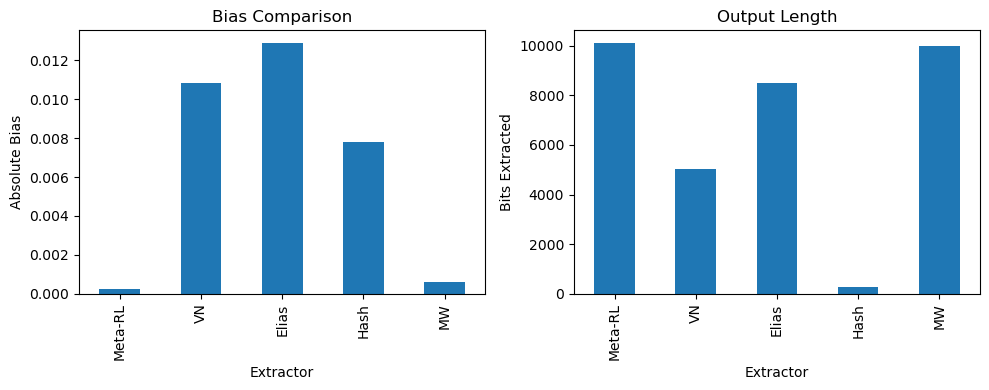

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,4))


df['Bias'].plot.bar(ax=axes[0], title='Bias Comparison')
axes[0].set_ylabel('Absolute Bias')

# Output Length
df['OutLen'].plot.bar(ax=axes[1], title='Output Length')
axes[1].set_ylabel('Bits Extracted')

plt.tight_layout()
plt.show()


In [30]:

!pip install nistrng


  Using cached nistrng-1.2.3.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nistrng: filename=nistrng-1.2.3-py3-none-any.whl size=38179 sha256=2635a23c36788be77d398e6bf16c3eb16e573aa2884c0e9052893c059d0d2184
  Stored in directory: c:\users\ereci\appdata\local\pip\cache\wheels\1c\8b\b4\9748dc9b9309d26efb89edfb91f5f04ce89c6716f5ef413482
Successfully built nistrng


  DEPRECATION: Building 'nistrng' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'nistrng'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [ ]:
import numpy as np
from nistrng import (
    SP800_22R1A_BATTERY,
    check_eligibility_all_battery,
    run_all_battery
)

def nist_pass_rate(bits: list[int]) -> tuple[int,int]:
    seq = np.array(bits, dtype=np.int8)
    eligible = check_eligibility_all_battery(seq, SP800_22R1A_BATTERY)
    results  = run_all_battery(seq, eligible, False)
    passed   = sum(1 for res,_ in results if res.passed)
    total    = len(results)
    return passed, total

p_raw, n_raw = nist_pass_rate(raw)
print(f"Raw Qiskit‐Aer stream: {p_raw}/{n_raw} tests passed ({p_raw/n_raw:.2%})")


Raw Qiskit‐Aer stream: 10/11 tests passed (90.91%)


In [ ]:
# Pure‑Python SP 800‑22 via nistrng 

import numpy as np
import pandas as pd
from nistrng import (
    SP800_22R1A_BATTERY,
    check_eligibility_all_battery,
    run_all_battery
)


binary_sequence = np.array(raw, dtype=np.int8)   


eligible = check_eligibility_all_battery(
    binary_sequence,
    SP800_22R1A_BATTERY
)


results = run_all_battery(
    binary_sequence,
    eligible,
    False
)

# Building a DataFrame of p‑values, pass/fail, and timing
rows = []
for result_obj, elapsed_ms in results:
    rows.append({
        "Test":     result_obj.name,
        "p_value":  result_obj.score,
        "pass":     result_obj.passed,
        "time_ms":  elapsed_ms
    })

df_nist = pd.DataFrame(rows).set_index("Test")
df_nist


,p_value,pass,time_ms
Test,,,
Monobit,0.218560,True,0
Frequency Within Block,0.832654,True,0
Runs,0.923867,True,1
Longest Run Ones In A Block,0.502836,True,7
Discrete Fourier Transform,0.745603,True,0
Non Overlapping Template Matching,1.000000,True,32
Serial,0.894166,True,362
Approximate Entropy,0.779168,True,485
Cumulative Sums,0.233002,True,13


In [38]:
#  Comparing Pass‐Rates for Each Extractor 
import numpy as np
import pandas as pd
from nistrng import (
    SP800_22R1A_BATTERY,
    check_eligibility_all_battery,
    run_all_battery
)

def pass_rate(bits):
    seq = np.array(bits, dtype=np.int8)
    eligible = check_eligibility_all_battery(seq, SP800_22R1A_BATTERY)
    results = run_all_battery(seq, eligible, False)
    total = len(results)
    passed = sum(1 for res, _ in results if res.passed)
    return passed, total

# Building the streams dict (reuse raw, meta_out, etc.)
streams = {
    'Raw':     raw,
    'VN':      von_neumann(raw_bits),
    'Elias':   elias(raw_bits),
    'Hash':    universal_hash(raw_bits, seed="seed"),
    'MW':      ExtractorEnv._bytes_to_bits(
                   maurer_wolf_extractor(bits_to_bytes(raw_bits),
                                        seed=b"seed",
                                        output_len=len(raw_bits)//2)
               ),
    'Meta‑RL': meta_out
}

# Computing pass‐rates
data = []
for name, bits in streams.items():
    p, n = pass_rate(bits)
    data.append({'Extractor': name,
                 'Passed':    p,
                 'Total':     n,
                 'PassRate':  p/n})

df_rates = pd.DataFrame(data).set_index('Extractor')
df_rates


,Passed,Total,PassRate
Extractor,,,
Raw,10,11,0.909091
VN,9,11,0.818182
Elias,8,11,0.727273
Hash,9,11,0.818182
MW,9,11,0.818182
Meta‑RL,10,11,0.909091


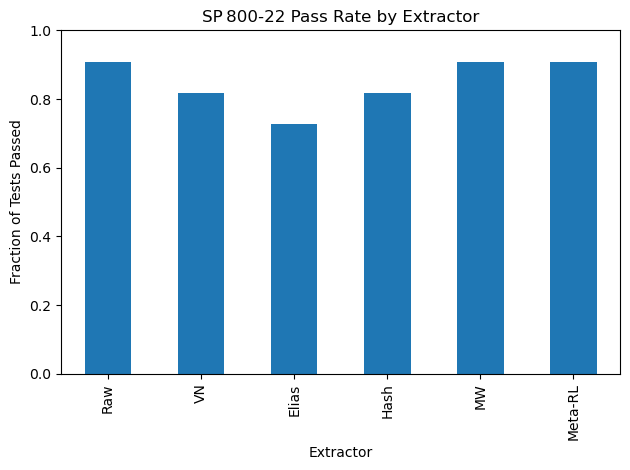

In [35]:
ax = df_rates['PassRate'].plot.bar(
    title='SP 800‑22 Pass Rate by Extractor', ylim=(0,1)
)
ax.set_ylabel('Fraction of Tests Passed')
plt.tight_layout()
plt.show()


In [ ]:

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

def generate_qrng(n_qubits: int, shots: int) -> np.ndarray:
    """
    Run an n_qubits Hadamard circuit and return an array of shape (shots, n_qubits) of bits.
    """
    qc = QuantumCircuit(n_qubits, n_qubits)
    for q in range(n_qubits):
        qc.h(q)
    for q in range(n_qubits):
        qc.measure(q, q)
    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    bits = np.zeros((shots, n_qubits), dtype=np.int8)
    idx = 0
    for bitstring, freq in counts.items():
        arr = np.array(list(bitstring), dtype=np.int8)
        bits[idx : idx + freq, :] = arr
        idx += freq
    return bits


sample_bits = generate_qrng(n_qubits=2, shots=5)
print("Sample 2-qubit bits (5 shots):")
print(sample_bits)


import gym
from gym import spaces

class QRNGEnvMultiBit(gym.Env):
    """
    Gym environment where observation = n_qubits-bit QRNG output.
    Example action: agent guesses the next bitstring.
    """
    metadata = {"render.modes": ["human"]}
    def __init__(self, n_qubits=2, max_steps=100):
        super().__init__()
        assert n_qubits >= 1, "n_qubits must be at least 1"
        self.n_qubits = n_qubits
        self.max_steps = max_steps
        self.step_count = 0

        
        self.observation_space = spaces.MultiBinary(self.n_qubits)
        
        self.action_space = spaces.Discrete(2 ** self.n_qubits)

    def reset(self):
        self.step_count = 0
       
        bits_array = generate_qrng(self.n_qubits, shots=1)
        obs = bits_array[0]  # shape = (n_qubits,)
        return obs

    def step(self, action: int):
        self.step_count += 1

        
        bits_array = generate_qrng(self.n_qubits, shots=1)
        true_bits = bits_array[0]
        true_int = int("".join(true_bits.astype(str)), 2)

        #  Reward if agent guessed correctly
        reward = 1.0 if action == true_int else 0.0

        # Done if we reached max_steps
        done = (self.step_count >= self.max_steps)

        # Observation for next step: return the true_bits
        next_obs = true_bits

        return next_obs, reward, done, {}

    def render(self, mode="human"):
        pass

    def close(self):
        pass

# Example Usage of the Environment
env = QRNGEnvMultiBit(n_qubits=3, max_steps=10)
obs = env.reset()
print("\nInitial observation (3-qubit):", obs)

total_reward = 0
for step_idx in range(10):
    action = env.action_space.sample()
    next_obs, reward, done, info = env.step(action)
    print(f"Step {step_idx+1}: obs={next_obs}, action={action}, reward={reward}, done={done}")
    total_reward += reward
    obs = next_obs
    if done:
        break

print("\nTotal reward in this episode:", total_reward)
env.close()



Sample 2-qubit bits (5 shots):
[[0 1]
 [1 0]
 [1 0]
 [0 0]
 [1 1]]

Initial observation (3-qubit): [0 0 1]
Step 1: obs=[0 1 0], action=6, reward=0.0, done=False
Step 2: obs=[0 1 0], action=4, reward=0.0, done=False
Step 3: obs=[1 0 1], action=6, reward=0.0, done=False
Step 4: obs=[0 1 0], action=3, reward=0.0, done=False
Step 5: obs=[1 1 0], action=2, reward=0.0, done=False
Step 6: obs=[0 1 0], action=4, reward=0.0, done=False
Step 7: obs=[1 1 1], action=3, reward=0.0, done=False
Step 8: obs=[1 0 1], action=5, reward=1.0, done=False
Step 9: obs=[1 0 0], action=5, reward=0.0, done=False
Step 10: obs=[0 1 0], action=2, reward=1.0, done=True

Total reward in this episode: 2.0


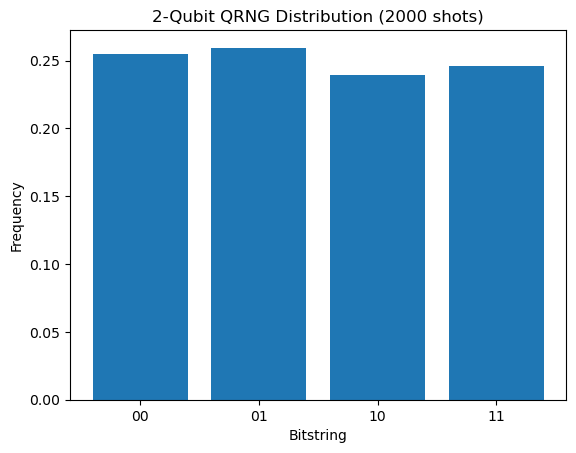

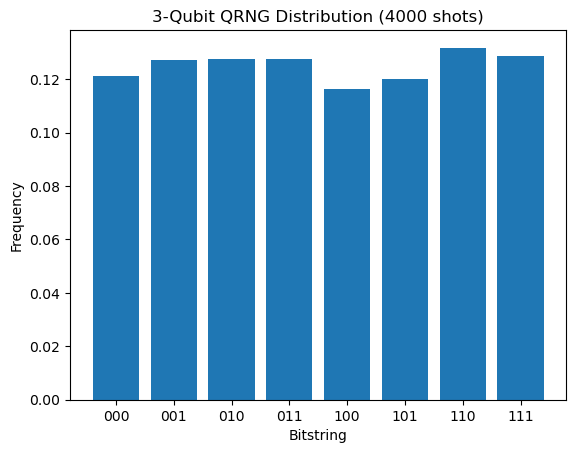

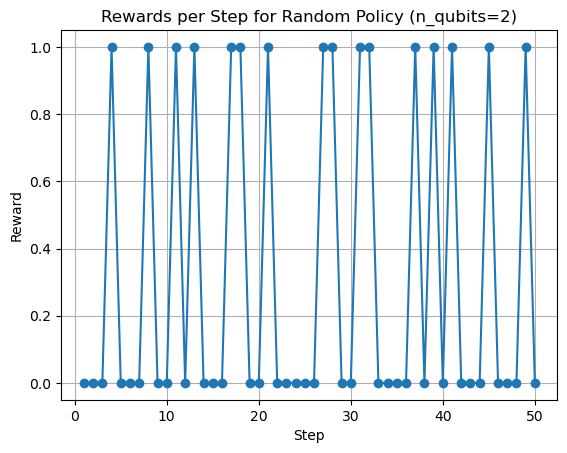

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

#QRNG distribution for 2-qubit and 3-qubit circuits
for n_qubits, shots in [(2, 2000), (3, 4000)]:
    samples = generate_qrng(n_qubits=n_qubits, shots=shots)
    # Convert each row of bits into integer
    int_values = np.array([int("".join(row.astype(str)), 2) for row in samples])
    # Count frequencies
    counts = np.bincount(int_values, minlength=2**n_qubits)
    freqs = counts / shots
    
    # Bar chart
    labels = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    plt.figure()
    plt.bar(labels, freqs)
    plt.title(f"{n_qubits}-Qubit QRNG Distribution ({shots} shots)")
    plt.xlabel("Bitstring")
    plt.ylabel("Frequency")
    plt.show()

# Rewards per step for a random policy in the environment (n_qubits=2)
env = QRNGEnvMultiBit(n_qubits=2, max_steps=50)
obs = env.reset()
rewards = []
steps = []
for step_idx in range(50):
    action = env.action_space.sample()
    obs, r, done, _ = env.step(action)
    rewards.append(r)
    steps.append(step_idx + 1)
    if done:
        break

plt.figure()
plt.plot(steps, rewards, marker='o')
plt.title("Rewards per Step for Random Policy (n_qubits=2)")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


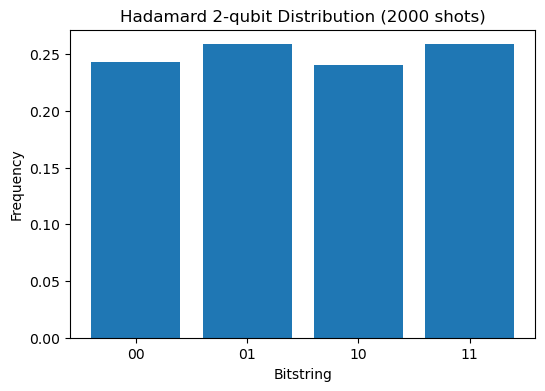

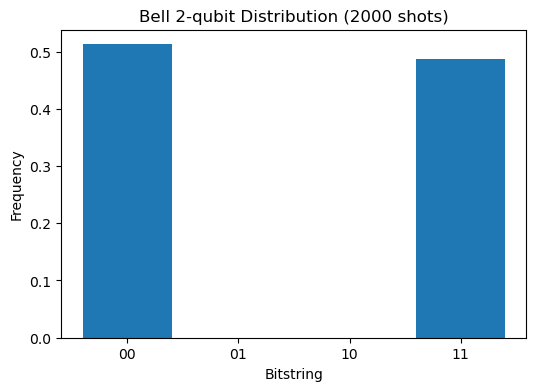

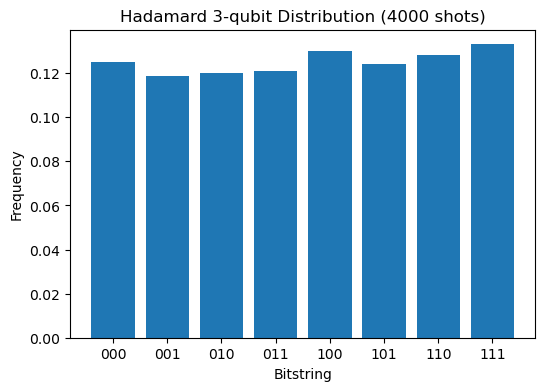

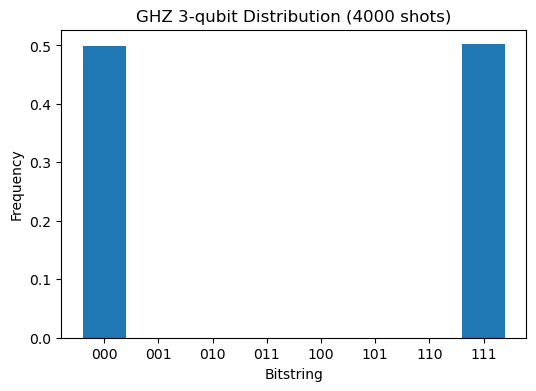

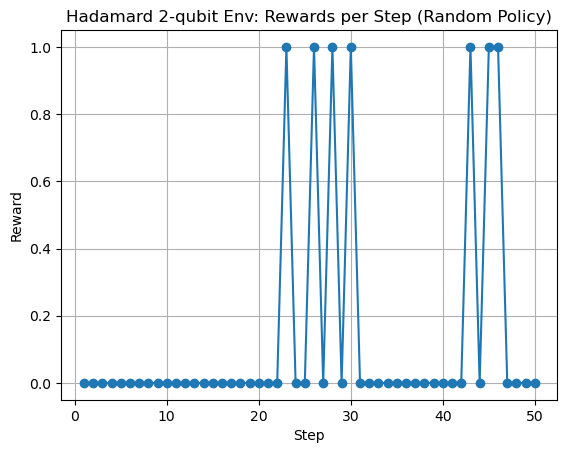

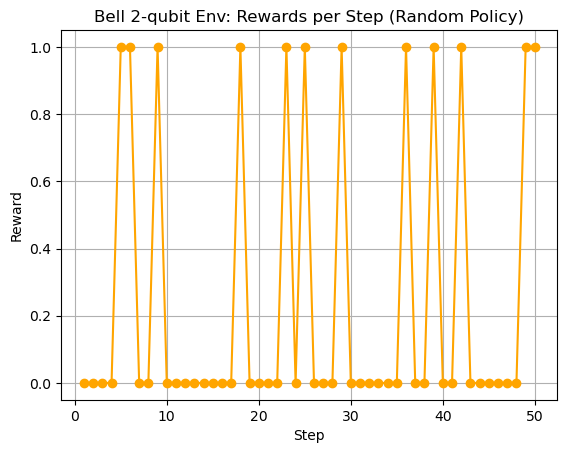

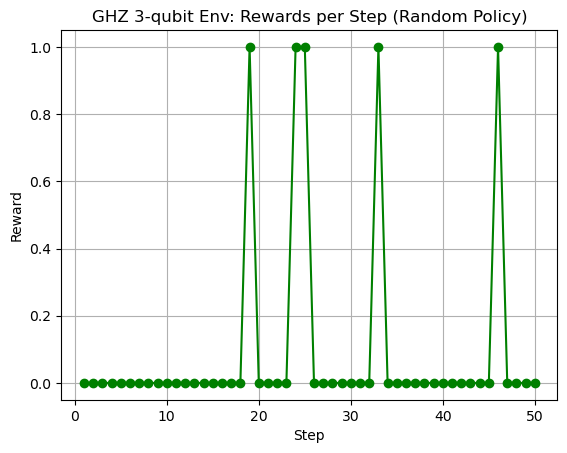

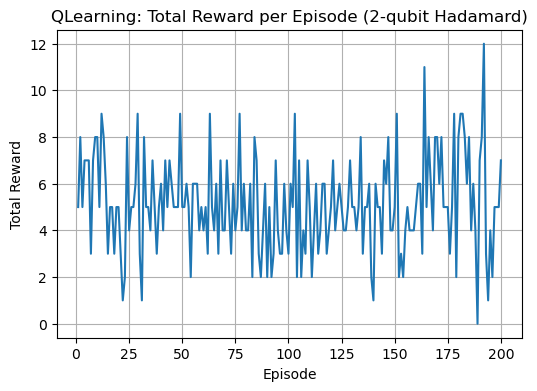

Final Q-table (shape 4x4):
[[2.05942817 1.88598322 1.90498935 2.07035758]
 [1.89574827 1.6000826  2.57223421 1.90001618]
 [1.88000184 1.92416559 1.76739932 1.94227813]
 [2.24966585 1.96998647 1.98880508 1.67345619]]


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import gym
from gym import spaces



# Different QRNG generator functions

def generate_hadamard_qrng(n_qubits: int, shots: int) -> np.ndarray:
    """
    Standard QRNG: apply H to each qubit, then measure.
    Returns array shape (shots, n_qubits).
    """
    qc = QuantumCircuit(n_qubits, n_qubits)
    for q in range(n_qubits):
        qc.h(q)
    for q in range(n_qubits):
        qc.measure(q, q)
    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    bits = np.zeros((shots, n_qubits), dtype=np.int8)
    idx = 0
    for bitstring, freq in counts.items():
        arr = np.array(list(bitstring), dtype=np.int8)
        bits[idx: idx + freq, :] = arr
        idx += freq
    return bits

def generate_bell_qrng(shots: int) -> np.ndarray:
    """
    2-qubit entangled QRNG: generates Bell pair (|00> + |11>)/sqrt(2) and measures.
    Returns array shape (shots, 2), bits either [0,0] or [1,1].
    """
    n_qubits = 2
    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])
    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    bits = np.zeros((shots, n_qubits), dtype=np.int8)
    idx = 0
    for bitstring, freq in counts.items():
        arr = np.array(list(bitstring), dtype=np.int8)
        bits[idx: idx + freq, :] = arr
        idx += freq
    return bits

def generate_ghz_qrng(shots: int) -> np.ndarray:
    """
    3-qubit GHZ-state QRNG: generates (|000> + |111>)/sqrt(2) and measures.
    Returns array shape (shots, 3), bits are [0,0,0] or [1,1,1].
    """
    n_qubits = 3
    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.measure([0, 1, 2], [0, 1, 2])
    sim = AerSimulator()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    bits = np.zeros((shots, n_qubits), dtype=np.int8)
    idx = 0
    for bitstring, freq in counts.items():
        arr = np.array(list(bitstring), dtype=np.int8)
        bits[idx: idx + freq, :] = arr
        idx += freq
    return bits

# RL environment that integrates a custom QRNG generator

class QRNGEnvFlexible(gym.Env):
    """
    Gym environment where observation is n_qubits-bit random output from a provided QRNG generator.
    The agent must guess the next bitstring to receive a reward.
    Supports different QRNG functions (Hadamard, Bell, GHZ).
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, n_qubits: int, qrng_func, max_steps: int = 100):
        """
        - n_qubits: number of qubits for observation; can be 1, 2, or 3.
        - qrng_func: a function that takes `shots` (and optionally `n_qubits`) and returns array (shots, n_qubits).
                     E.g., generate_hadamard_qrng, generate_bell_qrng (for 2-qubit), generate_ghz_qrng (for 3-qubit).
        - max_steps: episode length.
        """
        super().__init__()
        self.n_qubits = n_qubits
        self.qrng_func = qrng_func
        self.max_steps = max_steps
        self.step_count = 0

        # Observation: n_qubits-length bit vector
        self.observation_space = spaces.MultiBinary(self.n_qubits)
        # Action: integer guess in [0 .. 2^n_qubits - 1]
        self.action_space = spaces.Discrete(2 ** self.n_qubits)

    def reset(self):
        self.step_count = 0
        # Draw one n_qubits-bit sample
        bits = (
            self.qrng_func(shots=1)
            if self.qrng_func in [generate_bell_qrng, generate_ghz_qrng]
            else self.qrng_func(self.n_qubits, shots=1)
        )
        obs = bits[0]
        return obs

    def step(self, action: int):
        self.step_count += 1
        bits = (
            self.qrng_func(shots=1)
            if self.qrng_func in [generate_bell_qrng, generate_ghz_qrng]
            else self.qrng_func(self.n_qubits, shots=1)
        )
        true_bits = bits[0]
        true_int = int("".join(true_bits.astype(str)), 2)
        reward = 1.0 if action == true_int else 0.0
        done = (self.step_count >= self.max_steps)
        next_obs = true_bits
        return next_obs, reward, done, {}

    def render(self, mode="human"):
        pass

    def close(self):
        pass



for title, func, n_qubits, shots in [
    ("Hadamard 2-qubit", generate_hadamard_qrng, 2, 2000),
    ("Bell 2-qubit", generate_bell_qrng, 2, 2000),
    ("Hadamard 3-qubit", generate_hadamard_qrng, 3, 4000),
    ("GHZ 3-qubit", generate_ghz_qrng, 3, 4000),
]:
    if func in [generate_bell_qrng, generate_ghz_qrng]:
        samples = func(shots=shots)
    else:
        samples = func(n_qubits=n_qubits, shots=shots)
    int_vals = np.array([int("".join(row.astype(str)), 2) for row in samples])
    counts = np.bincount(int_vals, minlength=2**n_qubits)
    freqs = counts / shots
    labels = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    plt.figure(figsize=(6,4))
    plt.bar(labels, freqs)
    plt.title(f"{title} Distribution ({shots} shots)")
    plt.xlabel("Bitstring")
    plt.ylabel("Frequency")
    plt.show()

#  Rewards per Step under Random Policy for each environment

# (a) Hadamard 2-qubit
env_h2 = QRNGEnvFlexible(n_qubits=2, qrng_func=generate_hadamard_qrng, max_steps=50)
obs = env_h2.reset()
rewards = []
for _ in range(50):
    action = env_h2.action_space.sample()
    obs, r, done, _ = env_h2.step(action)
    rewards.append(r)
    if done:
        break
plt.figure()
plt.plot(range(1, len(rewards)+1), rewards, marker='o')
plt.title("Hadamard 2-qubit Env: Rewards per Step (Random Policy)")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# (b) Bell 2-qubit
env_b2 = QRNGEnvFlexible(n_qubits=2, qrng_func=generate_bell_qrng, max_steps=50)
obs = env_b2.reset()
rewards = []
for _ in range(50):
    action = env_b2.action_space.sample()
    obs, r, done, _ = env_b2.step(action)
    rewards.append(r)
    if done:
        break
plt.figure()
plt.plot(range(1, len(rewards)+1), rewards, marker='o', color='orange')
plt.title("Bell 2-qubit Env: Rewards per Step (Random Policy)")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# (c) GHZ 3-qubit
env_g3 = QRNGEnvFlexible(n_qubits=3, qrng_func=generate_ghz_qrng, max_steps=50)
obs = env_g3.reset()
rewards = []
for _ in range(50):
    action = env_g3.action_space.sample()
    obs, r, done, _ = env_g3.step(action)
    rewards.append(r)
    if done:
        break
plt.figure()
plt.plot(range(1, len(rewards)+1), rewards, marker='o', color='green')
plt.title("GHZ 3-qubit Env: Rewards per Step (Random Policy)")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()



class QLearningAgent:
    def __init__(self, n_states: int, n_actions: int, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.Q = np.zeros((n_states, n_actions))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
    
    def select_action(self, state: int) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[state])
    
    def update(self, s, a, r, s_next, done):
        best_next = np.max(self.Q[s_next])
        target = r + (0 if done else self.gamma * best_next)
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

def bits_to_int(bits: np.ndarray) -> int:
    return int("".join(bits.astype(str)), 2)

# Training loop
env_q = QRNGEnvFlexible(n_qubits=2, qrng_func=generate_hadamard_qrng, max_steps=20)
agent = QLearningAgent(n_states=4, n_actions=4, alpha=0.2, gamma=0.9, epsilon=0.2)

num_episodes = 200
rewards_per_episode = []

for ep in range(num_episodes):
    bits = env_q.reset()
    state = bits_to_int(bits)
    total_reward = 0
    done = False
    
    while not done:
        action = agent.select_action(state)
        next_bits, reward, done, _ = env_q.step(action)
        next_state = bits_to_int(next_bits)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    rewards_per_episode.append(total_reward)

# Plot learning curve
plt.figure(figsize=(6,4))
plt.plot(range(1, num_episodes+1), rewards_per_episode)
plt.title("QLearning: Total Reward per Episode (2-qubit Hadamard)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

# Print final Q-table
print("Final Q-table (shape 4x4):")
print(agent.Q)


In [ ]:
#comitting my milestone
!git tag -a v0.7 -m "Milestone 7: complete"


!git push origin v0.7


To https://github.com/WarriorErik/QRANDOPT.git
 * [new tag]         v0.5 -> v0.5
